In [2]:
import emcee
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
#from scipy.signal import find_peaks,argrelmin
from scipy.stats import median_absolute_deviation
import eleanor
import urllib
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import TessTargetPixelFile
import eleanor
from astropy.io import ascii,fits
from astropy.table import Table,join,Column
import astropy.units as u
import bokeh
import sys
from scipy.signal import savgol_filter
from requests.exceptions import HTTPError
import matplotlib.gridspec as gridspec
plt.rcParams['font.size']=12
import glob
from PyPDF2 import PdfFileMerger,PdfFileReader
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
import pandas as pd
from astroquery.gaia import Gaia
from uncertainties.umath import *
from uncertainties import ufloat
from uncertainties import unumpy
import statsmodels.distributions.empirical_distribution as emp
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs
from scipy.stats import norm,uniform,t
from random import choices
from scipy.stats import ks_2samp, anderson_ksamp, kstest
from random import choices

plt.rcParams['font.size']= 18

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
def calc_posterior(meanv,sigv,meanu,sigu):

    varr = np.linspace(0,150,10000)
    cosiarr = np.linspace(0,0.999,1000)
    #cosiarr = np.linspace(0,1.999,2000)

    
    lv = norm.pdf(varr,meanv,sigv)
    pv = uniform.pdf(varr,0,np.max(varr))
    pcosi = uniform.pdf(cosiarr,0,1)
    post = []
    for i in range(len(cosiarr)):
        lu = norm.pdf(varr*np.sqrt(1-cosiarr[i]**2),meanu,sigu)
        area = np.trapz(lu,varr)
        lu = lu/area
        post += [pcosi[i]*np.trapz(lv*lu*pv,varr)]
    post = np.array(post)
    
    return cosiarr,post

def calc_posterior_sini(meanv,sigv,meanu,sigu):

    #varr = np.linspace(0,300,30000)
    varr = np.linspace(0,10000,1e5)

    #cosiarr = np.linspace(0,0.999,1000)
    
    siniarr = np.linspace(0.00,2.000,2000)

    
    lv = norm.pdf(varr,meanv,sigv)
    pv = uniform.pdf(varr,0,np.max(varr))
    #pcosi = uniform.pdf(cosiarr,0,1)
    psini = uniform.pdf(siniarr,0,2.000)

    post = []
    for i in range(len(siniarr)):
        #lu = norm.pdf(varr*siniarr[i],meanu,sigu)
        lu = t.pdf(varr*siniarr[i],loc=meanu,scale=sigu,df=2)
        area = np.trapz(lu,varr)
        lu = lu/area
        post += [psini[i]*np.trapz(lv*lu*pv,varr)]
    post = np.array(post)
    
    return siniarr,post

In [1635]:
siniarr,post = calc_posterior_sini(75.5,2,75,9)

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


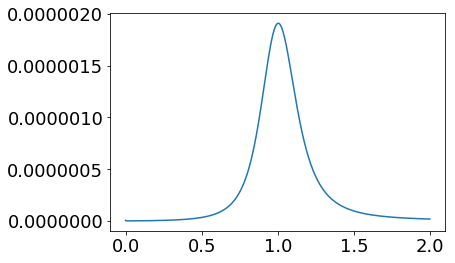

In [1639]:
plt.plot(siniarr,post)


/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


1.0000000000000002 0.9999999999999999
4.1547284189097055e-06


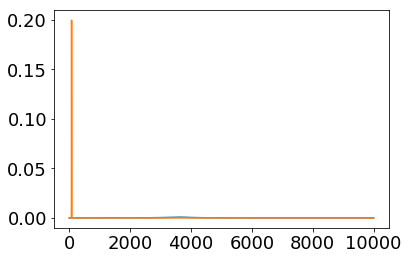

In [1625]:
varr = np.linspace(0,10000,1e6)
siniarr = np.linspace(0.001,2.002,2000)

lu = t.pdf(varr*siniarr[20],loc=75,scale=9,df=2)
lv = norm.pdf(varr,loc=75.5,scale=2)
lvstretch = norm.pdf(varr,loc=75.5,scale=2*5)

area = np.trapz(lu,varr)
area2 = np.trapz(lv,varr)
area3 = np.trapz(lvstretch,varr)


lu = lu/area
lv = lv/area2
lvstretch = lvstretch/area3

plt.plot(varr,lu)
plt.plot(varr,lv)
#plt.plot(varr,lvstretch)

#plt.xlim(0,20)
print(np.trapz(lu,varr),np.trapz(lv,varr))
print(np.trapz(lv*lu,varr))

In [1542]:
lu[7551] - lu[7550]

2.4651882595168057e-07

In [1548]:
siniarr[200]

0.20113342228152103

In [1528]:
area

1.2369774150730122

In [4]:
allmems = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_allCGmems.dat')
allmems.sort(keys='bp_rp')
highprob = (allmems['proba'] > 0.68) & (~np.isnan(allmems['bp_rp'])) #& ~((allmems['bp_rp'] > 1) & (allmems['phot_g_mean_mag'] < 8))


In [5]:
allmems[highprob]

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8
119.91698179846047,-60.20730290913189,5290847861214655616,273.4097728019546,-15.42662065710891,2.4527904346249043,0.033296657626091505,-5.691359173268097,0.06467164581475626,10.775704639634146,0.0628861100800557,0.09279045,-0.041820534,-0.057156306,0.008887227,0.17312391,0.077231996,-0.250947,0.37346554,-0.13382107,0.006634741,445,6.2626743,-0.032298565,1.0,NGC_2516
120.92347226164134,-60.90750623116792,5290024533163062144,274.2925144464865,-15.323833878671998,2.38695081266727,0.03733233081021125,-4.322659177281228,0.07563342464480956,11.272285125118083,0.07246332425329853,0.17067564,0.16761108,0.016199568,0.043572016,0.33409497,0.086991735,-0.3497119,0.12214134,-0.060588226,0.16407593,409,8.262502,-0.0077381134,0.699999988079071,NGC_2516
119.02007429823331,-60.242650314474844,5290949669118299776,273.22747990936904,-15.837485686614025,2.382342546339042,0.030884364205279888,-4.614197241025308,0.06163745889203402,11.036018372172514,0.06001523717009677,0.082458355,0.14978021,-0.22619416,0.06747159,0.3288977,0.08065303,-0.26148266,0.03384889,-0.010761007,-0.004673507,348,8.848627,0.04133606,0.8999999761581421,NGC_2516
119.62801458151493,-60.729014545974856,5290816009737675392,273.8195892311944,-15.79632782011264,2.3459198144502693,0.05317615387828988,-4.724103428767031,0.10278447815380688,11.487546813193461,0.08280422038728018,-0.33268985,-0.24652441,-0.1548819,-0.026355078,0.58386004,0.025687002,-0.03477466,0.12079637,-0.04705079,-0.24031103,349,8.760657,0.053194046,0.800000011920929,NGC_2516
119.18789627550726,-60.81503064475218,5290722929205920640,273.79579424462383,-16.02667189058346,2.3364959869964177,0.03937319594646655,-4.672949876984168,0.09931554849647194,11.364220666923254,0.07549219425688103,0.17142186,0.015435569,-0.11975494,0.063805185,0.23300102,0.09580875,-0.21163876,0.0037664748,-0.07602048,0.2447253,352,8.315389,0.0631752,0.8999999761581421,NGC_2516
119.83869142894031,-60.815619059384105,5290767150189898496,273.94900258505027,-15.745614609747308,2.3148033380110076,0.04770177347965338,-4.2800369217775875,0.11115529255333499,9.717774621470877,0.09020166045527815,-0.092175476,-0.13398156,0.02492849,-0.048716858,0.3323382,-0.044829473,-0.050216362,0.07946961,-0.10111479,-0.10974758,374,9.057377,0.08256626,0.699999988079071,NGC_2516
118.3718083148051,-61.05443958533375,5290702279003050496,273.8310339705176,-16.488568259288407,2.3945796959135244,0.037674198925095576,-3.8079083801083238,0.08230730879440029,10.964100414195437,0.07622033566083534,-0.038439356,0.0060356553,-0.15159078,0.10084648,0.32652462,0.1677019,-0.4733641,0.24937662,-0.053883355,0.008115692,387,7.7965913,0.0906291,0.8999999761581421,NGC_2516
119.59272824743998,-60.856155075718064,5290673897859442304,273.9283514664737,-15.870574551224594,2.399346209164383,0.057630735416954744,-5.229491703805306,0.12995133433546097,11.260807277579998,0.10115626321113508,-0.18746535,-0.053691782,-0.00064099167,0.028780892,0.15700845,0.074295886,-0.11790566,0.36536905,-0.24762312,-0.2681794,359,7.947094,0.09343624,0.8999999761581421,NGC_2516
118.96086835234338,-61.169145797709746,5290662383047290496,274.07149211297536,-16.286274918870625,2.3772888459035175,0.035867427176972944,-4.518255906789538,0.07019720600391673,11.888855088109151,0.063071623136456,0.05325894,0.11645161,-0.15364216,0.09411886,0.36138755,0.19405887,-0.2686812,0.25523877,-0.088182054,-0.05989211,329,8.1349945,0.09464455,0.699999988079071,NGC_2516


In [6]:
#finalresults = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/ngc2516finalresultstbl46_ultimate.dat')
finalresults

source_id,AV_SFD,AV_SandF,Cluster,E_B_V_SFD,E_B_V_SandF,Hmag,Icmag,Jmag,Kmag,Nsp,Object,RV,S/N,Survey,al_fe,alpha_fe,b,ba_fe,bp_rp,c_fe,ca_fe,chi2_cannon,classification,cluster,co_fe,cr_fe,cu_fe,cutout_size,dec,dec_parallax_corr,dec_pmdec_corr,dec_pmra_corr,dej2000,e_al_fe,e_alpha_fe,e_ba_fe,e_c_fe,e_ca_fe,e_co_fe,e_cr_fe,e_cu_fe,e_eu_fe,e_fe_h,e_hmag,e_jmag,e_k_fe,e_kmag,e_la_fe,e_li_fe,e_logg,e_mg_fe,e_mn_fe,e_na_fe,e_ni_fe,e_o_fe,e_rv_nogr_obst,e_rv_obst,e_rv_synt,e_sc_fe,e_si_fe,e_teff,e_ti_fe,e_v_fe,e_vmic,e_vsini,e_y_fe,e_zn_fe,errmsg,eu_fe,fe_h,field_id,flag_al_fe,flag_ba_fe,flag_c_fe,flag_ca_fe,flag_cannon,flag_co_fe,flag_cr_fe,flag_cu_fe,flag_eu_fe,flag_k_fe,flag_la_fe,flag_li_fe,flag_mg_fe,flag_mn_fe,flag_na_fe,flag_ni_fe,flag_o_fe,flag_sc_fe,flag_si_fe,flag_ti_fe,flag_v_fe,flag_y_fe,flag_zn_fe,gaia_r,hmag,jmag,k_fe,kmag,l,la_fe,li_fe,logTeff,logg,max_E_B_V_SFD,max_E_B_V_SandF,mean_E_B_V_SFD,mean_E_B_V_SandF,mg_fe,min_E_B_V_SFD,min_E_B_V_SandF,mn_fe,na_fe,ndfclass,ni_fe,o_fe,pRV,parallax,parallax_err,parallax_error,parallax_pmdec_corr,parallax_pmra_corr,period,period_unc,phot_g_mean_mag,phot_g_n_obs,pmdec,pmdec_error,pmra,pmra_error,pmra_pmdec_corr,proba,pvsini,ra,ra_dec_corr,ra_parallax_corr,ra_pmdec_corr,ra_pmra_corr,raj2000,rv_nogr_obst,rv_obst,rv_synt,sc_fe,si_fe,snr_c1,snr_c2,snr_c3,snr_c4,sobject_id,sp_label_distance,star_id,stdev_E_B_V_SFD,stdev_E_B_V_SandF,teff,ti_fe,v_fe,vmag_jk,vmic,vsini,y_fe,zn_fe,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,exofast_r,r_hi_err,r_lo_err,exofast_teff,teff_hi_err,teff_lo_err,lum,lumhierr,lumloerr,sini,sini_fracerr
int64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,str16,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,str1,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5290652938419483904,0.6338,0.5451,NGC2516,0.2045,0.1758,11.42,0.0,11.7,11.3,2.0,07582084-6111460,20.9,95.67,GES,nan,nan,-16.030439035259093,nan,0.9394865,nan,nan,nan,C,NGC_2516,nan,nan,nan,5.0,-61.196060838358804,0.37400427,-0.24502419,0.13007003,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,60.56534926590163,nan,nan,nan,1.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0471351146697998,nan,nan,nan,nan,274.24034263679124,nan,nan,3.763,nan,0.2156,0.1854,0.2063,0.1774,nan,0.2005,0.1725,nan,nan,nan,nan,nan,0.29,2.436716979472706,0.01627388280104693,0.01627388280104693,-0.13387366,0.08670595,2.549453124781848,0.022903515727459193,12.957845,433,11.951098618869937,0.02845701370959519,-4.6436402653322775,0.03241088992530812,0.022855317,0.8999999761581421,0.05,119.58680314089415,0.076882124,0.13634558,0.07464604,-0.26808608

In [7]:
finalresults = finalresults[finalresults['proba'] > 0.68]

In [8]:
SSMgrv = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516_papertbls_singlestars_GESgalah_goodRV.dat')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bhealy/Documents/PhD_Thesis/NGC_2516_papertbls_singlestars_GESgalah_goodRV.dat'

In [109]:
newFR = join(SSMgrv,finalresults,keys='source_id')

In [110]:
excluded = []
included = []
for i in range(len(finalresults)):
    if finalresults['source_id'][i] in newFR['source_id'].data:
        excluded += [False]
        included += [True]
    else:
        excluded += [True]
        included += [False]

In [111]:
finalresults[excluded]['source_id','vsini','e_vsini','period','period_unc','exofast_r','gaia_r']

source_id,vsini,e_vsini,period,period_unc,exofast_r,gaia_r
int64,float64,float64,float64,float64,float64,float64
5290738356723303936,29.67578682208951,0.9124218862367368,1.0104049312207053,0.02290281524303354,1.462,1.5186703000000001
5291032132489758208,37.58166797675197,0.9994989758678856,1.4493867740314463,0.022902797010748908,1.455,1.4584261
5291032613526130048,25.721781704801685,0.8499990167459184,0.5380964198876815,0.016137466051052846,1.758,1.688003


In [4]:
#finalresults = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/finalresults_cdips_42.dat')

finalresults = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/joinedfinalresults_ultimate_cdips.dat')

finalperiods = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/final_verified_periods_68conf.dat')


In [4]:
finalperiods#[finalperiods['source_id']==5290739937276199168]

source_id,period,e_period,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,ra,dec,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_g_mean_flux_over_error,e_bp_rp,e_gmag
int64,float64,float64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64
5289890495822656640,1.989866134025422,0.021245756424717755,0.43750813929364085,0.0,0.013176402047905867,1,C,119.49936785349912,-61.45191965058128,274.45652443155785,-16.18563905846991,2.3928190531459097,0.01890695217759307,-4.393270268704721,0.039592181423995655,11.401475527243258,0.037162114672072595,0.012834066,0.034496877,-0.3020553,0.030143429,0.23014058,0.058823388,-0.2513722,0.08350046,-0.1359186,-0.007402256,455,12.709742,0.9228382,0.699999988079071,NGC_2516,3.1241972000000002,297.19097999999997,0.0,0.0,838.0806,1330.0022,2463.5435,0.0015301764488046433,0.000440631920524295
5289898020605414016,2.2345069945390725,0.022345069945390726,0.5520938388071954,0.0,0.0,1,C,119.98416898329307,-61.32024360559023,274.4470383089242,-15.91888146770759,2.362036220041,0.022592674318478393,-4.712546041542891,0.04576224817146788,11.733439840450455,0.04675409759308582,0.094471,0.051852487,-0.053004943,0.08687148,0.30354747,0.10655951,-0.2859684,0.06595268,-0.11679387,0.16156341,413,12.634859,0.8862591,0.8999999761581421,NGC_2516,7.240514,376.11475,0.0,0.0,804.4677,1333.1135,2243.0884,0.0015751867543111239,0.0004839284347933976
5289930181318610432,2.046413995219128,0.04082453826112902,0.5104268584400415,0.06611682078975804,0.05311584717240069,1,C,121.13929660975464,-61.34479131354677,274.7422043965664,-15.442528365609865,2.3884908308201847,0.03956593795486762,-5.996325742897152,0.07986416562888808,11.285662861416583,0.06402113272147258,-0.09037766,-0.3883745,-0.67335325,0.09366239,0.36055145,0.20421809,-0.3568515,0.5064942,-0.19008742,-0.045431316,264,10.764917,0.4116087,0.800000011920929,NGC_2516,8.342107,304.49652000000003,0.0,1.2560739669470197e-15,1046.4696,1272.1495,2971.7459999999996,0.0013426194989962054,0.0003652915051445631
5289934751163440000,1.5833218432962897,0.22916500363498926,0.20832924637943506,0.022902631951581452,0.021245497850816367,1,C,121.15734269335677,-61.250432702202865,274.6607323173441,-15.389518896548115,2.4388671345052253,0.026805866704714697,-5.4977469463723265,0.05465186967286327,11.431481500600079,0.04818195625532095,0.12255578,0.07034077,-0.07658734,-0.081400275,0.2666709,0.0258292,-0.31808743,0.35445124,-0.11345839,0.05156331,204,11.357195,0.59317017,0.800000011920929,NGC_2516,9.478527,401.3126,0.0,0.0,873.8053,1591.1505,1710.5907,0.0014166488568545035,0.0006345287457064957
5289958425026796288,0.33868801078892175,0.00833327267318964,0.06250125635415316,0.0,0.008333500847220421,1,C,121.28565505123679,-61.18736195636068,274.6343536109714,-15.304977045816903,2.4091882002309433,0.05364721138081558,-5.010441469558942,0.11122766528660019,11.31696637052315,0.10035107447776305,0.05425949,-0.031743843,-0.28042758,-0.047183275,0.22311863,0.0013237105,-0.23248485,0.20772423,-0.12612036,0.10145538,440,16.926434,2.1946259,0.699999988079071,NGC_2516,0.79059106,238.37921,0.0,0.0,115.03782,269.498,817.1237,0.010213779517166942,0.0013279169134911642
5289982713061723008,3.833304915577174,0.12499907333403826,0.8125160783529282,0.3435530170975104,0.30602212278932905,1,C,120.9091449058326,-61.202491894163856,274.5576027083697,-15.471302280161437,2.3652509368700576,

In [5]:
finalresults

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,Cluster,Object,Icmag,Jmag,Hmag,Kmag,S/N,RV,vsini,logTeff,Nsp,pRV,pvsini,gaia_r,parallax_err,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,survey,sobject_id,field_id,raj2000,dej2000,jmag,hmag,kmag,vmag_jk,e_jmag,e_hmag,e_kmag,snr_c1,snr_c2,snr_c3,snr_c4,rv_synt,e_rv_synt,rv_obst,e_rv_obst,rv_nogr_obst,e_rv_nogr_obst,chi2_cannon,sp_label_distance,flag_cannon,teff,e_teff,logg,e_logg,fe_h,e_fe_h,vmic,e_vmic,e_vsini,alpha_fe,e_alpha_fe,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,y_fe,e_y_fe,flag_y_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,eu_fe,e_eu_fe,flag_eu_fe,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,exofast_r,r_hi_err,r_lo_err,exofast_teff,teff_hi_err,teff_lo_err,star_id,ndfclass,period,e_period,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_g_mean_flux_over_error,e_bp_rp,e_gmag,bayes_sini,bayes_sini_lo_err,bayes_sini_hi_err
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str7,str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str8,float64,float64,float64,float64,str3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
118.96424957852149,-60.9670225989847,5290715919819356800,273.88477447001804,-16.19289637953639,2.4116537829791986,0.03461708719397074,-4.447843575372962,0.07491290936048897,10.997788913428714,0.06566002678822505,-0.036261998,-0.10274949,-0.13393322,0.11895334,0.28956938,0.18289489,-0.33514327,0.18048467,-0.0056276266,0.0080021275,416,16.025776,1.8827343,0.699999988079071,NGC2516,07555144-6058015,0.0,13.8,13.02,12.81,64.16,23.4,55.2,3.634,4,0.47,0.04,0.7077617645263672,0.03461708719397074,NGC_2516,1.5641948,267.69177,0.11276155360300345,0.8914978971218483,GES,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,4305.266104917106,67.10202781978033,--,--,--,--,--,--,2.208,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.04166742414236069,0.0,0.008333484828472138,1,C,0.637,0.027000000000000003,0.031,4290.0,210.0,210.0,--,--,0.2214280855708888,0.010206184867177571,194.72037,510.5224,1045.8955,0.005951346456465483,0.0010375964799071364,0.38219109554777386,0.03201600800400206,0.03701850925462724
119.9654316150975,-60.36926980260596,5290830097230075904,273.56980489383

In [11]:
finalresults.remove_columns(('period','e_period'))

In [12]:
finalresults = join(finalresults,finalperiods)

(array([1., 0., 0., 5., 4., 7., 9., 2., 4., 1.]),
 array([20.9  , 21.467, 22.034, 22.601, 23.168, 23.735, 24.302, 24.869,
        25.436, 26.003, 26.57 ]),
 <a list of 10 Patch objects>)

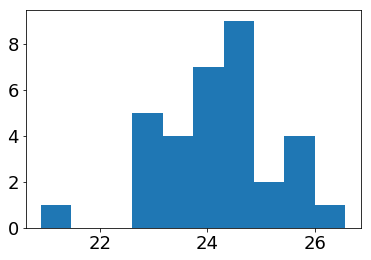

In [15]:
plt.hist(finalresults['RV'])

(18.5, 5.5)

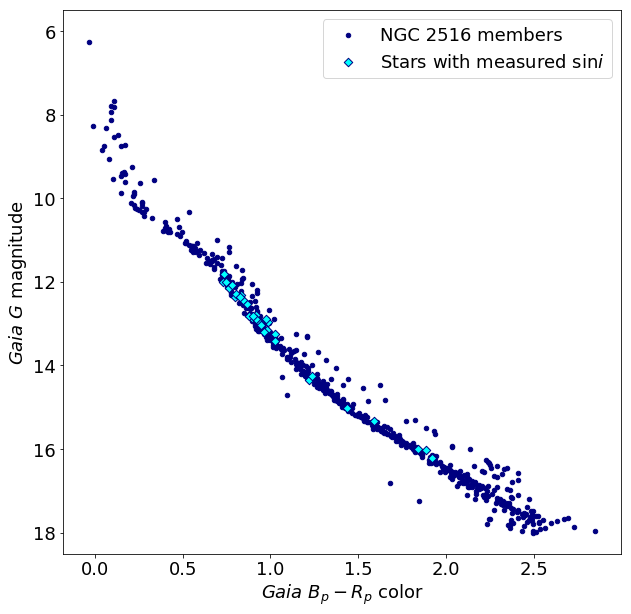

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='navy',s=20,label='NGC 2516 members')
#plt.scatter(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],color='orange',s=20)

plt.scatter(finalresults['bp_rp'],finalresults['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='Stars with measured $\sin i$')
#plt.errorbar(finalresults['bp_rp'],finalresults['phot_g_mean_mag'],xerr=finalresults['e_bp_rp'],yerr=finalresults['e_gmag'],color='black',label='',linestyle='none')

#plt.scatter(joined_finalresultstbl2['bp_rp'],joined_finalresultstbl2['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='Stars with measured $\sin i$')

#plt.scatter(finalresults[included]['bp_rp'],finalresults[included]['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='Stars with measured $\sin i$')
plt.legend()
plt.xlabel('$\it{Gaia}\ B_{p} - R_{p}$ color')
plt.ylabel('$\it{Gaia}\ G $ magnitude')

plt.ylim(18.5,5.5)

#plt.xlim(.65,1.1)
#plt.ylim(14,11)

#plt.xlim(1.7,2)
#plt.ylim(16.5,15.5)

In [112]:
#finalresults = finalresults[included]

In [551]:
#finalresults

In [205]:
corrunc_pers=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/vetperiods_corrunc_good.dat')

In [20]:
vsini = finalresults['vsini'].data
vsini_err = finalresults['e_vsini'].data

radius = finalresults['exofast_r'].data * 7e5
#old_radius_err = np.array([np.max((finalresults['r_hi_err'][i],finalresults['r_lo_err'][i])) for i in range(len(radius))])
radius_err = np.array([np.mean((finalresults['r_hi_err'][i],finalresults['r_lo_err'][i])) for i in range(len(radius))])
radius_err *= 7e5

period = finalresults['period'].data * 24 * 3600
period_err = finalresults['e_period'].data * 24 * 3600
#period_err = finalresults['period'].data * 24 * 3600 * 0.05

for i in range(len(period_err)):
    if period_err[i] == 0:
        nameindx = np.where(finalresults['source_id'][i] == corrunc_pers['source_id'])[0]
        period[i] = corrunc_pers[nameindx]['period'] * 24 * 3600
        period_err[i] = corrunc_pers[nameindx]['period_unc'] * 24 * 3600
        print(period_err[i]/period[i])
        #period_err[i] = 0.01 * period[i]

V = 2*np.pi*radius/period
V_err = V * np.sqrt((period_err/period)**2 + (radius_err/radius)**2)

(array([17.,  5.,  6.,  1.,  1.,  2.,  0.,  0.,  0.,  1.]),
 array([ 11.27270482,  24.78981108,  38.30691733,  51.82402359,
         65.34112985,  78.85823611,  92.37534237, 105.89244863,
        119.40955489, 132.92666115, 146.44376741]),
 <a list of 10 Patch objects>)

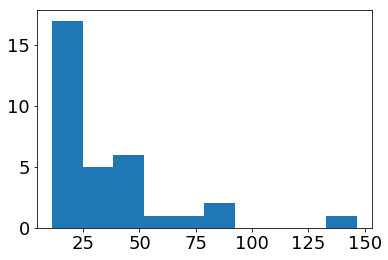

In [21]:
plt.hist(V)

In [419]:
vsini[1],vsini_err[1]

(10.7, 0.535)

In [22]:
Per = unumpy.uarray(period,period_err)
Rad = unumpy.uarray(radius,radius_err) #* .97
Vsini = unumpy.uarray(vsini, vsini_err)

In [23]:

incnames = []
# Calculate sini and its uncertainty
#Sini = (Per*Vsini)/(2*np.pi*Rad)
Sini = (Per*Vsini)/(2*np.pi*Rad)
sini = np.zeros(len(Sini))
sini_err = np.copy(sini)
for k in range(len(Sini)):
    incnames += [finalresults['source_id'][k]]
    Sinik = Sini[k]
    nomval = Sinik.nominal_value
    print(nomval)
    std_dev = Sinik.std_dev
    print(std_dev)
    sini[k] = nomval
    sini_err[k] = std_dev/nomval

# Calculate inclination from all sini values <= 1
Inclination = unumpy.arcsin(Sini[Sini<=1])

# Create separate arrays of inclination and uncertainty
err = np.zeros(len(Inclination))
inc = np.copy(sini_err)
for j in range(len(Inclination)):
    Ij = Inclination[j]
    nomval = Ij.nominal_value
    std_dev = Ij.std_dev

    inc[j] = nomval
    err[j] = std_dev#/nomval
incnames = np.array(incnames)

0.8257125090288785
0.0472654609207613
0.7799962716453046
0.045053346216397505
0.8047662740813321
0.06832086348442601
0.37693649225843706
0.028699526887469306
1.0759039959087338
0.058026952892964286
0.7061801090052479
0.046162797911742416
0.5570316554317555
0.025308918378012153
0.939345108705181
0.051575522926948045
0.5291295775258332
0.033078245749711396
1.0566213486538727
0.08286233509669162
0.836215444373457
0.05066893298335196
0.8508839375462578
0.04848338852037141
0.7353291255043609
0.040779143954927835
0.8474028389601571
0.047455353793282175
0.8143263646947735
0.04613181952808899
1.0108185417530735
0.041711927132386646
0.8557091494548595
0.04645998026717133
1.0537423192477247
0.05661938502580016
0.7652159505061129
0.03502858630846393
0.9942312247193812
0.12338517908530516
0.5922185872967928
0.04487914725416734
1.0335141468079803
0.051752338188142955
0.44612199577153244
0.039040863841789925
0.6830658768651474
0.045414919115253145
0.394856211881746
0.02150326190566981
0.854083843085

In [24]:
reasonable = (sini < 1.5) #& (sini >= 0.4)
unreasonable = ~reasonable
np.sum(unreasonable), len(sini)

(0, 33)

In [25]:
siniTbl = Table(data=[incnames,sini,sini_err],names=['source_id','eprop_sini','eprop_sini_err'])
siniTbl.sort(keys='eprop_sini')

In [26]:
np.sum(finalresults['survey'] == 'GES')

33

In [396]:
cosi_all = []
posteriors_all = []
best_cosi = []
for i in range(len(finalresults)):
    cosi_sing, posterior_sing = calc_posterior(V[i],V_err[i],vsini[i],vsini_err[i])
    cosi_all += [cosi_sing]
    posteriors_all += [posterior_sing]
    best_cosi += [cosi_sing[np.argmax(posterior_sing)]]

KeyboardInterrupt: 

In [ ]:
best_cosi = np.array(best_cosi)
posteriors_all = np.array(posteriors_all)
cosi_all = np.array(cosi_all)

In [533]:
#NEW: Use below code to directly compute sini

In [28]:
sini_all = []
posteriors_all = []
best_sini = []
for i in range(len(finalresults)):
    print(i)
    sini_sing, posterior_sing = calc_posterior_sini(V[i],V_err[i],vsini[i],vsini_err[i])
    sini_all += [sini_sing]
    posteriors_all += [posterior_sing]
    best_sini += [sini_sing[np.argmax(posterior_sing)]]

0


/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [29]:
best_sini = np.array(best_sini)
posteriors_all = np.array(posteriors_all)
sini_all = np.array(sini_all)

In [30]:
best_sini

array([0.82741371, 0.7813907 , 0.8084042 , 0.37818909, 1.07753877,
       0.70835418, 0.55827914, 0.94147074, 0.53026513, 1.05952976,
       0.83841921, 0.85242621, 0.73636818, 0.84942471, 0.8164082 ,
       1.01150575, 0.85742871, 1.05552776, 0.76638319, 1.00450225,
       0.59329665, 1.03451726, 0.44822411, 0.68534267, 0.3951976 ,
       0.85542771, 1.12056028, 0.76238119, 1.04752376, 1.02551276,
       0.93246623, 0.54127064, 0.93246623])

In [508]:
best_sini

array([0.82741371, 0.7813907 , 0.8084042 , 0.37818909, 1.07753877,
       0.70835418, 0.55827914, 0.94147074, 0.53026513, 1.05952976,
       0.83841921, 0.85242621, 0.73636818, 0.84942471, 0.8164082 ,
       1.01150575, 0.85742871, 1.05552776, 0.76638319, 1.00450225,
       0.59329665, 1.03451726, 0.44822411, 0.68534267, 0.3951976 ,
       0.85542771, 1.12056028, 0.76238119, 1.04752376, 1.02551276,
       0.93246623, 0.54127064, 0.93246623])

(array([3., 0., 4., 0., 3., 5., 6., 3., 4., 5.]),
 array([0.37818909, 0.45242621, 0.52666333, 0.60090045, 0.67513757,
        0.74937469, 0.82361181, 0.89784892, 0.97208604, 1.04632316,
        1.12056028]),
 <a list of 10 Patch objects>)

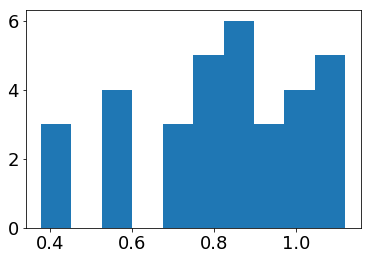

In [31]:
plt.hist(best_sini)

(array([2., 1., 4., 1., 2., 4., 7., 4., 5., 9.]),
 array([0.3841921 , 0.45222611, 0.52026013, 0.58829415, 0.65632816,
        0.72436218, 0.7923962 , 0.86043022, 0.92846423, 0.99649825,
        1.06453227]),
 <a list of 10 Patch objects>)

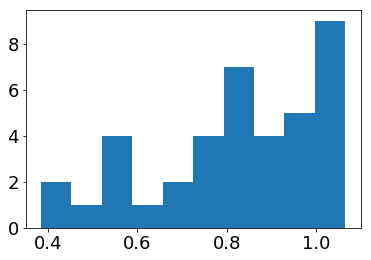

In [27]:
plt.hist(best_sini)

In [29]:
%matplotlib inline

In [350]:
nonzero = best_cosi != 0

In [32]:
posteriors_all.shape

(33, 2000)

In [510]:
i=33

#print(finalresults[i]['source_id','bayes_sini','sini_fracerr'])

for i in range(len(finalresults)):
    fig = plt.figure(figsize=(10,10))
    plt.plot(sini_all[i],posteriors_all[i])
    fig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/posteriors_sini/'+np.str(finalresults['source_id'][i])+'_'+np.str(i)+'.pdf',overwrite=True)
    plt.close()
    

In [33]:
bayes_sini=[]
bayes_sini_lo_err=[]
bayes_sini_hi_err=[]

#for i in range(len(finalresults[nonzero])):
#    sampled_cosi = np.array(choices(cosi_all[nonzero][i],posteriors_all[nonzero][i],k=100000))
for i in range(len(finalresults)):
    #sampled_cosi = np.array(choices(cosi_all[i],posteriors_all[i],k=100000))
    #sampled_sini = np.sqrt(1-sampled_cosi**2)
    sampled_sini = np.array(choices(sini_all[i],posteriors_all[i],k=100000))
    
    bayes_sini += [np.percentile(sampled_sini,50)]
    #bayes_sini += [np.percentile(sampled_sini,50)]

    bayes_sini_lo_err += [np.percentile(sampled_sini,50)- np.percentile(sampled_sini,16)]
    bayes_sini_hi_err += [np.percentile(sampled_sini,84)-np.percentile(sampled_sini,50)]
    
bayes_sini = np.array(bayes_sini)
bayes_sini_lo_err = np.array(bayes_sini_lo_err)
bayes_sini_hi_err = np.array(bayes_sini_hi_err)
    
    

In [34]:
bayes_sini[18]-2*bayes_sini_lo_err[18]

0.6843421710855428

In [35]:
bayes_sini[18]+bayes_sini_hi_err[18]

0.816408204102051

In [552]:
#USE this code now

In [50]:
len(finalresults)

42

In [524]:
bayes_sini=[]
bayes_sini_lo_err=[]
bayes_sini_hi_err=[]

#for i in range(len(finalresults[nonzero])):
#    sampled_cosi = np.array(choices(cosi_all[nonzero][i],posteriors_all[nonzero][i],k=100000))
for i in range(len(finalresults)):
    #sampled_sini = np.array(choices(sini_all[i],posteriors_all[i],k=1000000))
    #sampled_sini = np.sqrt(1-sampled_cosi**2)
    
    #bayes_sini += [np.mean(sampled_sini)]
    #bayes_sini += [np.median(sampled_sini)]
    
    bayes_index = np.where(posteriors_all[i] == np.max(posteriors_all[i]))[0][0]
    #print(bayes_index)
    bayes_sini += [sini_all[i][bayes_index]]
    #bayes_sini += [np.percentile(sampled_sini,50)]

    #bayes_sini_lo_err += [bayes_sini[i] - np.percentile(sampled_sini,16)]
    #bayes_sini_hi_err += [np.percentile(sampled_sini,84)-bayes_sini[i]]
    
    #bayes_sini_lo_err += [np.std(sampled_sini)]
    #bayes_sini_hi_err += [np.std(sampled_sini)]
    
    for j in range(0,bayes_index):
    #for j in range(0,len(sini_all[i]-bayes_index)):
        idx = bayes_index - j
        #if idx == 1:
            #print(i,'!',integral_ratio,sini_all[i][bayes_index])
        #    halfmax = 
        #    bayes_sini_lo_err += [bayes_sini[i] - sini_all[i][idx]]
        integral_ratio = np.trapz(posteriors_all[i][idx:bayes_index],sini_all[i][idx:bayes_index]) / np.trapz(posteriors_all[i],sini_all[i])
        integral_ratio = np.trapz(posteriors_all[i][idx:bayes_index],sini_all[i][idx:bayes_index]) / np.trapz(posteriors_all[i],sini_all[i])
        if integral_ratio < 0.34:
            continue
        #elif 
        else:
            bayes_sini_lo_err += [bayes_sini[i] - sini_all[i][idx]]
            #print(j)
            break
    for j in range(0,len(sini_all[i]-bayes_index)):
        idx = bayes_index + j
        integral_ratio = np.trapz(posteriors_all[i][bayes_index:idx],sini_all[i][bayes_index:idx]) / np.trapz(posteriors_all[i],sini_all[i])
        if integral_ratio < 0.34:
            continue
        else:
            bayes_sini_hi_err += [sini_all[i][idx] - bayes_sini[i]]
            break
    
bayes_sini = np.array(bayes_sini)
bayes_sini_lo_err = np.array(bayes_sini_lo_err)
bayes_sini_hi_err = np.array(bayes_sini_hi_err)
    
    

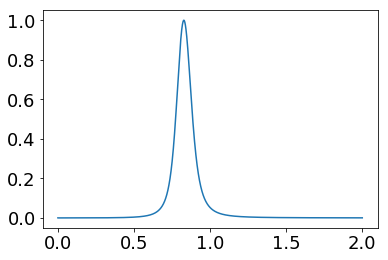

In [36]:
plt.plot(sini_all[0],posteriors_all[0]/np.max(posteriors_all[0]))

In [91]:
bayes_sini[0]

1.0615307653826913

In [90]:
bayes_sini_lo_err[0]

0.07803901950975489

In [86]:
sini_all[18][np.argmax(posteriors_all[18])]

0.8534267133566783

In [37]:
sampled_sini = np.array(choices(sini_all[i],posteriors_all[i],k=100000))

In [38]:
joined_finalresultstbl['bayes_sini','bayes_sini_lo_err']

NameError: name 'joined_finalresultstbl' is not defined

In [39]:
bayes_sini_lo_err

array([0.05702851, 0.05402701, 0.08104052, 0.03201601, 0.07103552,
       0.05602801, 0.03101551, 0.06203102, 0.03901951, 0.09504752,
       0.06003002, 0.05802901, 0.04902451, 0.05702851, 0.05502751,
       0.05002501, 0.05702851, 0.06903452, 0.04202101, 0.14207104,
       0.05002501, 0.06003002, 0.04602301, 0.05402701, 0.02601301,
       0.05802901, 0.09604802, 0.05302651, 0.07003502, 0.06903452,
       0.06403202, 0.04202101, 0.06303152])

In [40]:
bayes_sini_hi_err

array([0.06503252, 0.06203102, 0.09804902, 0.03701851, 0.07803902,
       0.06403202, 0.03501751, 0.07103552, 0.04502251, 0.10805403,
       0.06903452, 0.06603302, 0.05602801, 0.06503252, 0.06303152,
       0.05402701, 0.06403202, 0.07703852, 0.04802401, 0.17408704,
       0.05802901, 0.06503252, 0.05602801, 0.06203102, 0.03001501,
       0.06403202, 0.10905453, 0.05902951, 0.07803902, 0.07803902,
       0.07303652, 0.04902451, 0.06903452])

In [1652]:
bayes_sini_lo_err

array([0.07003502, 0.14607304, 0.06103052, 0.05002501, 0.04902451,
       0.04502251, 0.04502251, 0.08504252, 0.09604802, 0.05502751,
       0.06903452, 0.06103052, 0.05102551, 0.04702351, 0.04002001,
       0.06403202, 0.06203102, 0.06703352, 0.05602801, 0.03301651,
       0.05802901, 0.05402701, 0.04702351, 0.07303652, 0.05402701,
       0.05902951, 0.09204602, 0.06203102, 0.06503252, 0.05102551,
       0.04902451, 0.04702351, 0.06903452, 0.04402201, 0.07003502,
       0.03201601, 0.05702851, 0.02301151, 0.06303152])

In [1653]:
bayes_sini_hi_err

array([0.06803402, 0.13906953, 0.05802901, 0.04602301, 0.04702351,
       0.04302151, 0.04302151, 0.08204102, 0.09004502, 0.05202601,
       0.06703352, 0.05802901, 0.04902451, 0.04502251, 0.03701851,
       0.06103052, 0.05902951, 0.06503252, 0.05302651, 0.03101551,
       0.05602801, 0.05102551, 0.04602301, 0.07003502, 0.05202601,
       0.05602801, 0.08804402, 0.06003002, 0.06103052, 0.04802401,
       0.04802401, 0.04602301, 0.06503252, 0.04202101, 0.06803402,
       0.03001501, 0.05602801, 0.02201101, 0.06103052])

In [41]:
#bayes_finalresults = Table(data=[finalresults[nonzero]['source_id'],bayes_sini,bayes_sini_lo_err,bayes_sini_hi_err],names=['source_id','bayes_sini','bayes_sini_lo_err','bayes_sini_hi_err'])

bayes_finalresults = Table(data=[finalresults['source_id'],bayes_sini,bayes_sini_lo_err,bayes_sini_hi_err],names=['source_id','bayes_sini','bayes_sini_lo_err','bayes_sini_hi_err'])






In [42]:
bayes_finalresults

source_id,bayes_sini,bayes_sini_lo_err,bayes_sini_hi_err
int64,float64,float64,float64
5290728834785867264,0.8314157078539269,0.057028514257128626,0.065032516258129
5290713652076611200,0.785392696348174,0.05402701350675332,0.06203101550775392
5290710800218328192,0.816408204102051,0.08104052026013009,0.09804902451225617
5290715919819356800,0.38219109554777386,0.03201600800400206,0.03701850925462724
5290715954179096320,1.0825412706353177,0.07103551775887951,0.07803901950975467
5290717672165866496,0.7123561780890445,0.056028014007003524,0.06403201600800401
5290737669533445248,0.5592796398199099,0.03101550775387696,0.03501750875437715
5291030448862535808,0.944472236118059,0.06203101550775392,0.0710355177588794
5290723032285137024,0.5332666333166582,0.03901950975487739,0.04502251125562784


In [43]:
bayes_finalresults

source_id,bayes_sini,bayes_sini_lo_err,bayes_sini_hi_err
int64,float64,float64,float64
5290728834785867264,0.8314157078539269,0.057028514257128626,0.065032516258129
5290713652076611200,0.785392696348174,0.05402701350675332,0.06203101550775392
5290710800218328192,0.816408204102051,0.08104052026013009,0.09804902451225617
5290715919819356800,0.38219109554777386,0.03201600800400206,0.03701850925462724
5290715954179096320,1.0825412706353177,0.07103551775887951,0.07803901950975467
5290717672165866496,0.7123561780890445,0.056028014007003524,0.06403201600800401
5290737669533445248,0.5592796398199099,0.03101550775387696,0.03501750875437715
5291030448862535808,0.944472236118059,0.06203101550775392,0.0710355177588794
5290723032285137024,0.5332666333166582,0.03901950975487739,0.04502251125562784


In [330]:
for i in range(len(siniTbl)):
    if siniTbl['source_id'][i] in bayes_finalresults['source_id']:
        print('!')
        indx = np.where(siniTbl['source_id'][i] == bayes_finalresults['source_id'])[0]
        siniTbl['comb_sini'][i] = bayes_finalresults['bayes_sini'][indx]
        siniTbl['comb_sini_err'][i] = np.mean((bayes_finalresults['bayes_sini_hi_err'][indx],np.mean(bayes_finalresults['bayes_sini_lo_err'])))
        
        
        
        
        

!


KeyError: 'comb_sini'

In [6]:
joined_finalresultstbl = finalresults
joined_finalresultstbl2 = finalresults

In [44]:


joined_finalresultstbl = join(finalresults,bayes_finalresults)
joined_finalresultstbl2 = join(finalresults,bayes_finalresults)

joined_finalresultstbl.sort('bayes_sini')
joined_finalresultstbl2.sort('bayes_sini')
#joined_finalresultstbl = join(finalresults,siniTbl)

Text(0,0.5,'sini from Bayesian statistics')

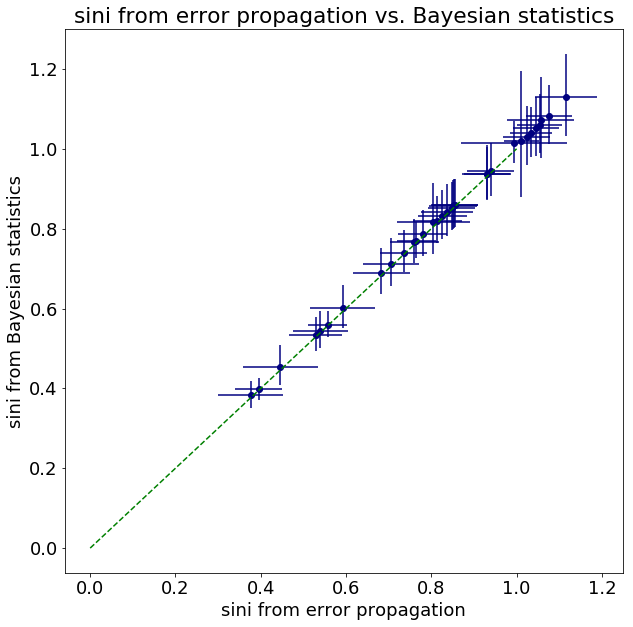

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(siniTbl['eprop_sini'],joined_finalresultstbl['bayes_sini'],color='navy')
plt.errorbar(siniTbl['eprop_sini'],joined_finalresultstbl['bayes_sini'],yerr = (joined_finalresultstbl['bayes_sini_lo_err'],joined_finalresultstbl['bayes_sini_hi_err']),xerr=siniTbl['eprop_sini_err'],linestyle='none',color='navy')
plt.plot([0,1],[0,1],color='green',linestyle='--')

plt.title('sini from error propagation vs. Bayesian statistics')
plt.xlabel('sini from error propagation')
plt.ylabel('sini from Bayesian statistics')



In [579]:
joined_finalresultstbl.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/joinedfinalresults_ultimate_cdips.dat',format='ascii')
#joined_finalresultstbl = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/joinedfinalresults_ultimate_cdips.dat')


In [118]:
np.max(bayes_finalresults['bayes_sini_hi_err']-bayes_finalresults['bayes_sini_lo_err'])

0.025800920460230192

In [367]:
len(sampled_sini)

100000

In [119]:
#joined_finalresultstbl.sort('bayes_sini')
joined_finalresultstbl.sort('teff')

In [120]:
joined_finalresultstbl[-20:-10]['source_id','teff','exofast_r','period','period_unc','bayes_sini','bayes_sini_lo_err']

KeyError: 'period_unc'

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 3.0000e+00, 6.0000e+00, 7.0000e+00,
        3.0000e+00, 4.0000e+00, 8.0000e+00, 8.0000e+00, 9.0000e+00,
        6.0000e+00, 7.0000e+00, 1.1000e+01, 1.1000e+01, 1.7000e+01,
        1.8000e+01, 2.9000e+01, 2.6000e+01, 3.1000e+01, 4.0000e+01,
        5.0000e+01, 6.4000e+01, 7.6000e+01, 7.4000e+01, 1.1800e+02,
        1.3100e+02, 1.6000e+02, 2.4000e+02, 3.3600e+02, 4.1500e+02,
        5.7600e+02, 8.8500e+02, 1.2390e+03, 2.0150e+03, 3.2290e+03,
        4.8240e+03, 7.2430e+03, 9.8470e+03, 1.1393e+04, 1.2599e+04,
        1.1193e+04, 8.8290e+03, 6.7920e+03, 4.9110e+03, 3.1450e+03,
        2.2920e+03, 1.5640e+03, 1.1240e+03, 7.3500e+02, 5.8700e+02,
        4.6800e+02, 3.7200e+02, 2.8100e+02, 2.4000e+02, 2.1000e+02,
        1.6500e+02, 1.3600e+02, 1.2100e+02, 9.4000e+01, 9.5000e+01,
        7.7000e+01, 9.8000e+01, 6.3000e+01, 5.1000e+01, 3.9000e+01,
        5.0000e+01, 3.6000e+01, 4.5000e+01, 3.20

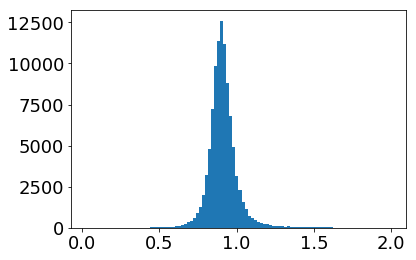

In [121]:
plt.hist(sampled_sini,bins=100)

In [1598]:
print(np.mean(sampled_sini), np.std(sampled_sini), np.std(sampled_sini)/np.mean(sampled_sini))

0.9550938225483657 0.0942687636808912 0.09870105057256555


In [200]:
print(np.mean(sampled_sini),np.mean(sampled_sini)- np.percentile(sampled_sini,16), np.percentile(sampled_sini,84)-np.mean(sampled_sini))

0.11534411742710081 0.03794256705503159 0.039109759183361695


In [436]:
joined_finalresultstbl.sort(keys='bayes_sini')

In [123]:
(joined_finalresultstbl['bayes_sini_hi_err']+joined_finalresultstbl['bayes_sini_lo_err'])/2

0.03251625812906453
0.028514257128564285
0.061530765382691366
0.027013506753376687
0.13906953476738365
0.04302151075537769
0.047523761880940485
0.03251625812906456
0.03951975987994
0.048024012006003036
0.07553776888444225


In [124]:
#sini_new = np.sqrt(1- best_cosi[nonzero]**2)
sini_new = np.sqrt(1- best_cosi**2)

NameError: name 'best_cosi' is not defined

In [257]:
#sini_new = joined_finalresultstbl['comb_sini']

In [7]:
def true_sini_distrib_specific(alpha,lamda,n=50000):
    alpha *= np.pi/180
    lamda *= np.pi/180
    
    Rn = np.random.random(n)
    Rnp = np.random.random(n)
    
    theta_n = np.arccos(1 - Rn*(1-np.cos(lamda)))
    Ptheta = (1 - np.cos(theta_n))/(1 - np.cos(lamda))
    phi_n = 2*np.pi*Rnp
    
    cosi_n = np.sin(alpha)*np.sin(theta_n)*np.cos(phi_n) + np.cos(alpha)*np.cos(theta_n)
    sini_n = np.sin(np.arccos(np.abs(cosi_n)))
    
    sini_n = np.sort(sini_n)
    
    return sini_n

def sini_distrib_interp(xdatapoints,alpha,lamda,n=50000):
    sini_n_true = true_sini_distrib_specific(alpha,lamda,n=n)
    
    if len(sini_n_true) != 0:
        mcincemp = emp.ECDF(sini_n_obs)
        mcincempx1 = mcincemp.x[1:]
        mcincempy1 = mcincemp.y[1:]
    else:
        mcincempy1 = np.zeros(len(xdatapoints)) + 1
        mcincempx1 = xdatapoints
        #mcincemp = emp.ECDF(sini_n_true)
    sini_n_obs = np.interp(xdatapoints,mcincempx1,mcincempy1)
    
    
    
    return sini_n_obs

In [8]:
def true_sini_distrib(alpha,lamda,n=50000):
    alpha *= np.pi/180
    lamda *= np.pi/180
    
    Rn = np.random.random(n)
    Rnp = np.random.random(n)
    
    theta_n = np.arccos(1 - Rn*(1-np.cos(lamda)))
    Ptheta = (1 - np.cos(theta_n))/(1 - np.cos(lamda))
    phi_n = 2*np.pi*Rnp
    
    cosi_n = np.sin(alpha)*np.sin(theta_n)*np.cos(phi_n) + np.cos(alpha)*np.cos(theta_n)
    sini_n = np.sin(np.arccos(np.abs(cosi_n)))
    
    return sini_n



def obs_sini_distrib(alpha,lamda,deltap=0.1,deltav=0.1,deltar=0.1,cutoff=0,n=50000):
    sini_n_true = true_sini_distrib(alpha,lamda)
    
    U1 = np.random.normal(size=n)
    U2 = np.random.normal(size=n)
    
    deltapv = np.sqrt(deltap**2+deltav**2)
    
    sini_n_obs = sini_n_true #* ((1 + deltapv*U1)/(1 + deltar*U2))
    
    cutoffmask = np.zeros(len(sini_n_obs),dtype=bool)
    for i in range(len(sini_n_obs)):
        if sini_n_obs[i] > cutoff:
            cutoffmask[i] = True
    
    sini_n_obs = sini_n_obs[cutoffmask]
    
    return sini_n_obs

def true_sini_distrib_specific(alpha,lamda,n):
    alpha *= np.pi/180
    lamda *= np.pi/180
    
    Rn = np.random.random(n)
    Rnp = np.random.random(n)
    
    theta_n = np.arccos(1 - Rn*(1-np.cos(lamda)))
    Ptheta = (1 - np.cos(theta_n))/(1 - np.cos(lamda))
    phi_n = 2*np.pi*Rnp
    
    cosi_n = np.sin(alpha)*np.sin(theta_n)*np.cos(phi_n) + np.cos(alpha)*np.cos(theta_n)
    sini_n = np.sin(np.arccos(np.abs(cosi_n)))
    
    sini_n = np.sort(sini_n)
    
    return sini_n

def obs_sini_distrib_specific(xdatapoints,alpha,lamda,deltasini=0.11641160175478454,deltap=0.038906455369088946,deltav=0.05176470588235295,deltar=0.023155991748531755,cutoff=0.,n=50000):
    sini_n_true = true_sini_distrib_specific(alpha,lamda,n)
    
    U1 = np.random.normal(size=n)
    U2 = np.random.normal(size=n)
    
    deltapv = np.sqrt(deltap**2+deltav**2)
    
    sini_n_obs = sini_n_true #* ((1 + deltapv*U1)/(1 + deltar*U2))
    #print(sini_n_obs)
    
    cutoffmask = np.zeros(len(sini_n_obs),dtype=bool)
    for i in range(len(sini_n_obs)):
        if sini_n_obs[i] > cutoff:
            cutoffmask[i] = True
    
    sini_n_obs = sini_n_obs[cutoffmask]
    if len(sini_n_obs) != 0:
        mcincemp = emp.ECDF(sini_n_obs)
        mcincempx1 = mcincemp.x[1:]
        mcincempy1 = mcincemp.y[1:]
    else:
        mcincempy1 = np.zeros(len(xdatapoints)) + 1
        mcincempx1 = xdatapoints
        
    
    #sini_n_obs = np.interp(xdatapoints,mcincemp.x[1:],mcincemp.y[1:])
    sini_n_obs = np.interp(xdatapoints,mcincempx1,mcincempy1)

    
    return sini_n_obs

def obs_sini_distrib_uncerts(xdatapoints,alpha,lamda,deltasini=0.110/2,deltap=0.038906455369088946,deltav=0.05176470588235295,deltar=0.023155991748531755,cutoff=0.,n=50000):
    xdatapoints = np.sort(xdatapoints)
    sini_n_true = true_sini_distrib_specific(alpha,lamda,n)
    
    U1 = np.random.normal(size=n)
    U2 = np.random.normal(size=n)
    
    deltapv = np.sqrt(deltap**2+deltav**2)
    
    #print(np.mean((1 + deltapv*U1)/(1 + deltar*U2)))
    
    sini_n_obs = sini_n_true * ((1 + deltapv*U1)/(1 + deltar*U2))
    #sini_n_obs = sini_n_true * (1 + deltasini * U1)

    #print(xdatapoints)
    #print(sini_n_obs)
    
    cutoffmask = np.zeros(len(sini_n_obs),dtype=bool)
    for i in range(len(sini_n_obs)):
        if sini_n_obs[i] > cutoff:
            cutoffmask[i] = True
    
    sini_n_obs = sini_n_obs[cutoffmask]
    if len(sini_n_obs) != 0:
        mcincemp = emp.ECDF(sini_n_obs)
        mcincempx1 = mcincemp.x[1:]
        mcincempy1 = mcincemp.y[1:]
    else:
        mcincempy1 = np.zeros(len(xdatapoints)) + 1
        mcincempx1 = xdatapoints
        
    #print(mcincempx1)
    #print(mcincempy1)
    #sini_n_obs = np.interp(xdatapoints,mcincemp.x[1:],mcincemp.y[1:])
    #sini_n_obs = np.interp(xdatapoints,mcincempx1,mcincempy1)

    
    return sini_n_obs

def obs_sini_distrib_uncerts_specific(xdatapoints,alpha,lamda,deltasini=0.11641160175478454,deltap=0.038906455369088946,deltav=0.05176470588235295,deltar=0.023155991748531755
,cutoff=0.,n=50000):
    xdatapoints = np.sort(xdatapoints)
    sini_n_true = true_sini_distrib_specific(alpha,lamda,n)
    
    U1 = np.random.normal(size=n)
    U2 = np.random.normal(size=n)
    
    deltapv = np.sqrt(deltap**2+deltav**2)
    #print((1 + deltapv*U1)/(1 + deltar*U2))
    
    sini_n_obs = sini_n_true * ((1 + deltapv*U1)/(1 + deltar*U2))
    #print(xdatapoints)
    #print(sini_n_obs)
    
    cutoffmask = np.zeros(len(sini_n_obs),dtype=bool)
    for i in range(len(sini_n_obs)):
        if sini_n_obs[i] > cutoff:
            cutoffmask[i] = True
    
    sini_n_obs = sini_n_obs[cutoffmask]
    if len(sini_n_obs) != 0:
        mcincemp = emp.ECDF(sini_n_obs)
        mcincempx1 = mcincemp.x[1:]
        mcincempy1 = mcincemp.y[1:]
    else:
        mcincempy1 = np.zeros(len(xdatapoints)) + 1
        mcincempx1 = xdatapoints
        
    #print(mcincempx1)
    #print(mcincempy1)
    #sini_n_obs = np.interp(xdatapoints,mcincemp.x[1:],mcincemp.y[1:])
    sini_n_obs = np.interp(xdatapoints,mcincempx1,mcincempy1)

    
    return sini_n_obs

In [9]:
model_sini = obs_sini_distrib(10,15)
model_sini_ecdf = emp.ECDF(model_sini)

In [128]:
np.median((joined_finalresultstbl['bayes_sini_hi_err']+joined_finalresultstbl['bayes_sini_lo_err']/2)/joined_finalresultstbl['bayes_sini'])




0.11161689751637588

In [155]:
model_sini = obs_sini_distrib(54,47)
#model_sini = obs_sini_distrib(10,15)

model_sini_ecdf = emp.ECDF(model_sini)

[0.12300772 0.12474246 0.12497307 ... 1.         1.         1.        ]


Text(0,0.5,'Cumulative probability')

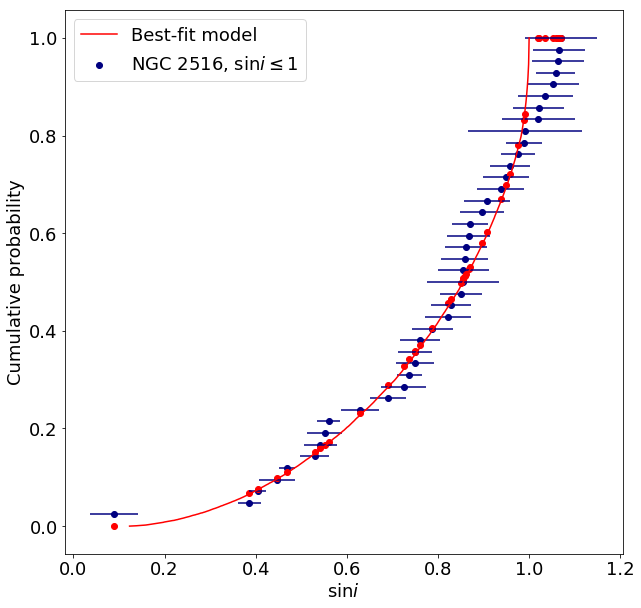

In [895]:
plt.figure(figsize=(10,10))
ecdf = emp.ECDF(joined_finalresultstbl['bayes_sini']) #emp.ECDF(sini_new)
old_ecdf = emp.ECDF(joined_finalresultstbl['sini'])

#model_sini_points = obs_sini_distrib_specific(ecdf.x[1:],20,85)
model_sini_points = obs_sini_distrib_specific(ecdf.x[1:],54,47)


plt.scatter(ecdf.x[1:],ecdf.y[1:],color='navy',label='NGC 2516, $\sin i \leq 1$')
#plt.scatter(old_ecdf.x[1:],old_ecdf.y[1:],color='orange')
#plt.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Theoretical [alpha=9, lambda=75]')
plt.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Best-fit model')

plt.scatter(ecdf.x[1:],model_sini_points,color='red')

plt.legend()
plt.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl['bayes_sini_hi_err']+joined_finalresultstbl['bayes_sini_lo_err'])/2,linestyle='none',color='navy')

#plt.errorbar(ecdf.x[1:],ecdf.y[1:],yerr=ecdf.y[-1]-ecdf.y[-2],xerr=(joined_finalresultstbl['bayes_sini_hi_err']+joined_finalresultstbl['bayes_sini_lo_err'])/2,linestyle='none',color='navy')
plt.xlabel('$\sin i$')
plt.ylabel('Cumulative probability')



In [824]:
print(model_sini_points)

[0.00431684 0.07877035 0.08691645 0.10783657 0.118148   0.15494596
 0.16188635 0.16785204 0.17427427 0.22803296 0.28306336 0.31997829
 0.3334007  0.34799472 0.34844722 0.36176989 0.39701654 0.44884481
 0.45796821 0.49649539 0.50323394 0.50583505 0.51025712 0.51543638
 0.52880507 0.53271892 0.5927123  0.61989427 0.69857339 0.73303678
 0.75550887 0.80799421 0.83958071 0.84520515 0.91557642 0.9164628
 0.93978063 0.96215236 0.96738837 0.97168038 0.97413757 0.97799865]


In [583]:
incempx1 = ecdf.x[1:]
incempy1 = ecdf.y[1:]

incempy1

array([0.03030303, 0.06060606, 0.09090909, 0.12121212, 0.15151515,
       0.18181818, 0.21212121, 0.24242424, 0.27272727, 0.3030303 ,
       0.33333333, 0.36363636, 0.39393939, 0.42424242, 0.45454545,
       0.48484848, 0.51515152, 0.54545455, 0.57575758, 0.60606061,
       0.63636364, 0.66666667, 0.6969697 , 0.72727273, 0.75757576,
       0.78787879, 0.81818182, 0.84848485, 0.87878788, 0.90909091,
       0.93939394, 0.96969697, 1.        ])

In [471]:
aa=50
ll=40
np.sum((incempy1 - obs_sini_distrib_specific(incempx1,aa,ll))**2 / obs_sini_distrib_specific(incempx1,aa,ll))





[0.1749094  0.17494816 0.17655363 ... 0.99999883 0.99999932 0.99999994]
[0.17418133 0.17496139 0.17607526 ... 0.99999994 0.99999998 0.99999999]


28.658149727358072

In [177]:
tefftbl = []
for i in range(len(joined_finalresultstbl)):
    teffi = np.str(np.int(joined_finalresultstbl['exofast_teff'][i]))
    teffiunc = np.str(np.int(joined_finalresultstbl['teff_hi_err'][i]))
    tefftbl += [teffi + ' magicsymb ' + teffiunc]
tefftbl = np.array(tefftbl)



In [178]:
radtbl = []
for i in range(len(joined_finalresultstbl)):
    radi = np.str(np.round(joined_finalresultstbl['exofast_r'][i],3))
    radiunc = np.str(np.round(radius_err[i]/7e5,3))
    radtbl += [radi + ' magicsymb ' + radiunc]
radtbl = np.array(radtbl)



In [195]:
vsinitbl = []
for i in range(len(joined_finalresultstbl)):
    vsinii = np.str(np.round(joined_finalresultstbl['vsini'][i],2))
    vsiniiunc = np.str(np.round(joined_finalresultstbl['e_vsini'][i],2))
    vsinitbl += [vsinii + ' magicsymb ' + vsiniiunc]
vsinitbl = np.array(vsinitbl)

vsinitbl

array(['12.8 magicsymb 0.64', '5.1 magicsymb 0.41', '19.5 magicsymb 0.58',
       '44.7 magicsymb 2.24', '14.1 magicsymb 0.7', '9.6 magicsymb 0.58',
       '8.6 magicsymb 0.34', '9.9 magicsymb 0.4', '7.7 magicsymb 0.38',
       '8.5 magicsymb 0.51', '10.7 magicsymb 0.54', '11.8 magicsymb 0.47',
       '12.5 magicsymb 0.62', '10.7 magicsymb 0.54',
       '19.2 magicsymb 0.96', '15.0 magicsymb 0.75',
       '35.2 magicsymb 1.76', '12.2 magicsymb 0.98',
       '13.1 magicsymb 0.66', '32.8 magicsymb 1.64', '68.0 magicsymb 3.4',
       '21.9 magicsymb 1.1', '19.1 magicsymb 0.57', '14.1 magicsymb 0.7',
       '38.1 magicsymb 1.91', '43.1 magicsymb 2.16', '27.9 magicsymb 1.4',
       '65.6 magicsymb 2.62', '24.1 magicsymb 0.72',
       '37.43 magicsymb 1.05', '75.0 magicsymb 9.0',
       '17.2 magicsymb 0.52', '46.9 magicsymb 2.35',
       '70.7 magicsymb 3.54', '37.6 magicsymb 1.88', '19.9 magicsymb 0.6',
       '21.8 magicsymb 1.09', '25.8 magicsymb 1.29',
       '28.6 magicsymb 1.43'], dty

In [210]:

periodtbl = []
for i in range(len(joined_finalresultstbl)):
    periodi = np.str(np.round(period[i]/86400,4))
    periodiunc = np.str(np.round(period_err[i]/86400,4))
    periodtbl += [periodi + ' magicsymb ' + periodiunc]
periodtbl = np.array(periodtbl)

periodtbl

array(['2.5495 magicsymb 0.0229', '0.4738 magicsymb 0.0042',
       '3.2727 magicsymb 0.0458', '4.1953 magicsymb 0.1145',
       '3.2188 magicsymb 0.1619', '3.2935 magicsymb 0.0687',
       '2.2899 magicsymb 0.0229', '2.4 magicsymb 0.1603',
       '3.7078 magicsymb 0.1603', '3.7269 magicsymb 0.0458',
       '2.019 magicsymb 0.0066', '3.0352 magicsymb 0.0687',
       '3.7869 magicsymb 0.0445', '1.8018 magicsymb 0.0229',
       '0.3905 magicsymb 0.0042', '1.5982 magicsymb 0.0458',
       '2.4369 magicsymb 0.0687', '3.1863 magicsymb 0.1145',
       '2.9322 magicsymb 0.0083', '3.2792 magicsymb 0.0229',
       '0.9667 magicsymb 0.0069', '3.1845 magicsymb 0.0458',
       '3.0786 magicsymb 0.0916', '0.6137 magicsymb 0.0051',
       '1.1155 magicsymb 0.0083', '2.3958 magicsymb 0.0229',
       '1.6646 magicsymb 0.0793', '1.5191 magicsymb 0.0229',
       '1.4131 magicsymb 0.0229', '2.6583 magicsymb 0.0264',
       '4.1624 magicsymb 0.0793', '2.5188 magicsymb 0.0648',
       '1.3048 magicsymb 0.0

In [212]:
tbl2 = Table(data=[joined_finalresultstbl['source_id'],np.round(joined_finalresultstbl['ra'],2),np.round(joined_finalresultstbl['dec'],2),np.round(joined_finalresultstbl['proba'],1),tefftbl,radtbl,vsinitbl,periodtbl,np.round(joined_finalresultstbl['bayes_sini'],4),np.round(joined_finalresultstbl['bayes_sini_hi_err'],4),np.round(joined_finalresultstbl['bayes_sini_hi_err'],4)],names=['sourceid','ra','dec','prob','teff','rad','vsini','period','sini','esinih','esinil'])





In [214]:
tbl2.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/tbl2.tex',format='latex')

In [332]:
#model_sini = obs_sini_distrib_uncerts(ecdf.x[1:],71,87)
#model_sini_ecdf = emp.ECDF(model_sini)

#model_sini_points = obs_sini_distrib_uncerts_specific(ecdf.x[1:],71,87)

[0.11534412 0.38852265 0.40569946 0.45242881 0.4697323  0.53492243
 0.54484136 0.55522354 0.56197679 0.63442694 0.69517516 0.73265947
 0.73986481 0.75439129 0.75449774 0.76697815 0.79502781 0.83495496
 0.83758818 0.86275321 0.87379585 0.87503044 0.87690657 0.87921725
 0.8807145  0.88145462 0.91308361 0.9249621  0.94823651 0.95586358
 0.96276123 0.9742441  0.97776691 0.99301043 1.0036195  1.01788444
 1.03188922 1.04917857 1.05501127 1.0585494  1.05896277 1.06210766]
[0.00735937 0.00848846 0.00866419 ... 1.09872003 1.0019382  0.97887682]
[0.00735937 0.00848846 0.00866419 ... 1.19410273 1.19979372 1.20360615]
[2.0000e-05 4.0000e-05 6.0000e-05 ... 9.9996e-01 9.9998e-01 1.0000e+00]
[0.11534412 0.38852265 0.40569946 0.45242881 0.4697323  0.53492243
 0.54484136 0.55522354 0.56197679 0.63442694 0.69517516 0.73265947
 0.73986481 0.75439129 0.75449774 0.76697815 0.79502781 0.83495496
 0.83758818 0.86275321 0.87379585 0.87503044 0.87690657 0.87921725
 0.8807145  0.88145462 0.91308361 0.9249621  0

In [335]:
l1ind = joined_finalresultstbl['comb_sini'] <= 1

In [193]:
keep_indx = np.zeros(len(joined_finalresultstbl),dtype='bool')
keep_indx[:] = True
keep_indx[3] = False
keep_indx[4] = False
keep_indx[6] = False
joined_finalresultstbl2 = joined_finalresultstbl[keep_indx] #np.copy(joined_finalresultstbl)

In [248]:
joined_finalresultstbl2.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/final34results.dat',format='ascii')

In [219]:
verified = ascii.read('/Users/bhealy/Downloads/verifythese.txt')
keep_indx = verified['good'].astype('bool')

In [221]:
joined_finalresultstbl2 = joined_finalresultstbl[keep_indx] #np.copy(joined_finalresultstbl)

In [484]:
joined_finalresultstbl2.sort('bayes_sini')

In [162]:
model_sini

array([0.25666437, 0.25295003, 0.25107475, ..., 0.99080757, 1.01482762,
       1.05324983])

In [5]:
#QUICK START
joined_finalresultstbl2 = finalresults
#joined_finalresultstbl2.sort('')

In [30]:
xdatapoints = np.arange(0.,2.,0.001)

In [553]:
model_sini_rand = obs_sini_distrib_uncerts(xdatapoints,75,90,cutoff=0.25,n=10000000)
model_sini_ecdf_rand = emp.ECDF(model_sini_rand)

model_sini_lowalign = obs_sini_distrib_uncerts(xdatapoints,15,45,cutoff=0.25,n=10000000)
model_sini_ecdf_lowalign = emp.ECDF(model_sini_lowalign)

model_sini_medalign = obs_sini_distrib_uncerts(xdatapoints,75,45,cutoff=0.25,n=10000000)
model_sini_ecdf_medalign = emp.ECDF(model_sini_medalign)

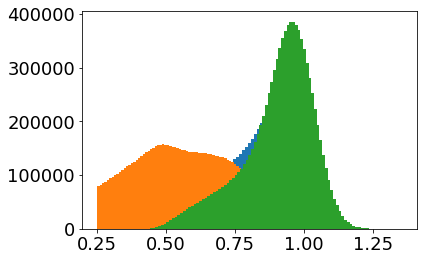

In [554]:
h_rand = plt.hist(model_sini_rand,bins=100)
h_lowalign = plt.hist(model_sini_lowalign,bins=100)
h_medalign = plt.hist(model_sini_medalign,bins=100)

In [555]:
centers_rand = np.array([(h_rand[1][i]+h_rand[1][i+1])/2 for i in range(len(h_rand[1])-1)])
prob_rand = h_rand[0]/len(model_sini_rand)

centers_lowalign = np.array([(h_lowalign[1][i]+h_lowalign[1][i+1])/2 for i in range(len(h_lowalign[1])-1)])
prob_lowalign = h_lowalign[0]/len(model_sini_lowalign)

centers_medalign = np.array([(h_medalign[1][i]+h_medalign[1][i+1])/2 for i in range(len(h_medalign[1])-1)])
prob_medalign = h_medalign[0]/len(model_sini_medalign)

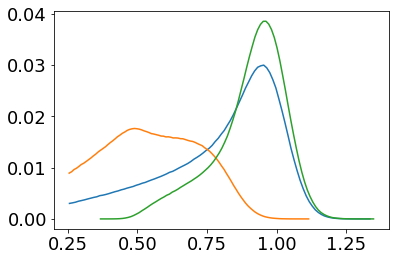

In [556]:
plt.plot(centers_rand,prob_rand)
plt.plot(centers_lowalign,prob_lowalign)
plt.plot(centers_medalign,prob_medalign)

In [557]:
rand_sini_10 = choices(centers_rand,prob_rand,k=10)
#rand_sini_30 = choices(centers_rand,prob_rand,k=30)
rand_sini_100 = choices(centers_rand,prob_rand,k=100)

lowalign_10 = choices(centers_lowalign,prob_lowalign,k=10)
lowalign_30 = choices(centers_lowalign,prob_lowalign,k=30)
lowalign_100 = choices(centers_lowalign,prob_lowalign,k=100)

medalign_10 = choices(centers_medalign,prob_medalign,k=10)
medalign_30 = choices(centers_medalign,prob_medalign,k=30)
medalign_100 = choices(centers_medalign,prob_medalign,k=100)

In [578]:
#rand_sini_30 = choices(centers_rand,prob_rand,k=30)
lowalign_30 = choices(centers_lowalign,prob_lowalign,k=30)
#medalign_30 = choices(centers_medalign,prob_medalign,k=30)


In [581]:
#model_sini = obs_sini_distrib_uncerts(xdatapoints,75,90,cutoff=0.25,n=5000)
#model_sini = obs_sini_distrib_uncerts(xdatapoints,75,30,cutoff=0.25,n=5000)

#model_sini = obs_sini_distrib_uncerts(xdatapoints,65,35,cutoff=0.25,n=5000)
#model_sini = obs_sini_distrib_uncerts(xdatapoints,15,45,cutoff=0.25,n=5000)
model_sini = obs_sini_distrib_uncerts(xdatapoints,75,45,cutoff=0.25,n=5000)



model_sini_ecdf = emp.ECDF(model_sini)
#mod_ecdf_x = np.concatenate(([0],model_sini_ecdf.x,[2]))
#mod_ecdf_y = np.concatenate(([0],model_sini_ecdf.y,[1]))

In [582]:
#ecdf_sim = emp.ECDF(rand_sini_30)
#ecdf_sim = emp.ECDF(lowalign_30)
ecdf_sim = emp.ECDF(medalign_30)

Text(0, 0.5, 'Cumulative probability')

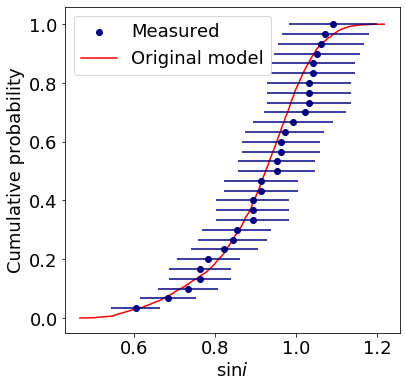

In [584]:
plt.rcParams['font.size']=18
fig,ax = plt.subplots(figsize=(6,6))
#ecdffig = plt.figure(figsize=(7,7))
#ecdf = emp.ECDF(sini_new)
#ecdf_sim = emp.ECDF(rand_sini_10)
#ecdf = emp.ECDF(joined_finalresultstbl2[:-1]['bayes_sini'])


#model_sini_points = obs_sini_distrib_uncerts(ecdf.x[1:],10,85)

ax.scatter(ecdf_sim.x[1:],ecdf_sim.y[1:],color='navy',label='Measured')#, $\sin i \leq 1$')
#plt.scatter(old_ecdf.x[1:],old_ecdf.y[1:],color='orange')
#plt.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Theoretical [alpha=9, lambda=75]')
ax.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Original model',zorder=0)
#ax.plot(ecdf_sim.x[1:],obs_sini_distrib_uncerts_specific(ecdf_sim.x[1:],75,45,cutoff=0.25,n=5000))

#plt.plot(model_sini_ecdf2.x[1:],model_sini_ecdf2.y[1:],color='orange',label='Best-fit model: cutoff=0.0',linestyle='--')

#plt.scatter(ecdf.x[1:],model_sini_points,color='red')


#plt.plot(ecdf.x[1:],model_sini_points,color='red')
handles, lbls = ax.get_legend_handles_labels()
ax.legend((handles[1],handles[0]),(lbls[1],lbls[0]),fontsize=18,ncol=1)

#plt.legend(loc=4)
#plt.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl['comb_sini_err']),linestyle='none',color='navy')
ax.errorbar(ecdf_sim.x[1:],ecdf_sim.y[1:],xerr=0.1*ecdf_sim.x[1:],linestyle='none',color='navy')

#plt.errorbar(ecdf.x[1:],ecdf.y[1:],yerr=ecdf.y[-1]-ecdf.y[-2],xerr=(joined_finalresultstbl['bayes_sini_hi_err']+joined_finalresultstbl['bayes_sini_lo_err'])/2,linestyle='none',color='navy')
ax.set_xlabel('$\sin i$')
ax.set_ylabel('Cumulative probability')

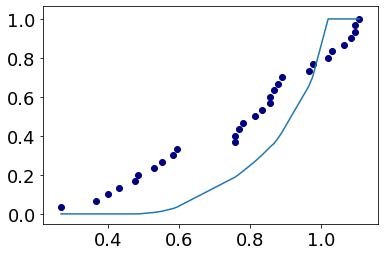

In [545]:
plt.scatter(ecdf_sim.x[1:],ecdf_sim.y[1:],color='navy',label='Measured')#, $\sin i \leq 1$')
plt.plot(ecdf_sim.x[1:],obs_sini_distrib_specific(ecdf_sim.x[1:],65,35,cutoff=0.25,n=5000))

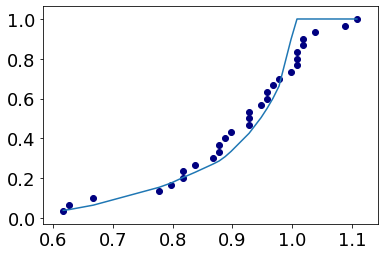

In [414]:
plt.scatter(ecdf_sim.x[1:],ecdf_sim.y[1:],color='navy',label='Measured')#, $\sin i \leq 1$')
plt.plot(ecdf_sim.x[1:],obs_sini_distrib_specific(ecdf_sim.x[1:],75,45,cutoff=0.25,n=5000))

In [9]:
onesigma_prob = joined_finalresultstbl2['proba'] > 0.68
#joined_finalresultstbl2 = joined_finalresultstbl2[onesigma_prob]
np.sum(onesigma_prob)/len(joined_finalresultstbl2)

1.0

In [534]:
#joined_finalresultstbl2 = joined_finalresultstbl2[:-1]

In [11]:
#model_sini = obs_sini_distrib_uncerts(ecdf.x[1:],55,89,cutoff=0.25,n=50000)
#model_sini = obs_sini_distrib_uncerts(ecdf.x[1:],56,90,cutoff=0.25,n=50000)
model_sini = obs_sini_distrib_uncerts(ecdf.x[1:],54,87,cutoff=0.25,n=50000)


model_sini_ecdf = emp.ECDF(model_sini)

#model_sini2 = obs_sini_distrib_uncerts(ecdf.x[1:],55,89)
#model_sini2 = obs_sini_distrib_uncerts(ecdf.x[1:],60,90)

#model_sini_ecdf2 = emp.ECDF(model_sini2)


#model_sini_points = obs_sini_distrib_uncerts_specific(ecdf.x[1:],54,47)
#model_sini_points = obs_sini_distrib_uncerts_specific(ecdf.x[1:],56,90,cutoff=0.25)
model_sini_points = obs_sini_distrib_uncerts_specific(ecdf.x[1:],54,87,cutoff=0.25)

#model_sini_points = obs_sini_distrib_uncerts_specific(ecdf.x[1:],20,29)

3775
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705


/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/anaconda3/envs/astroconda/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


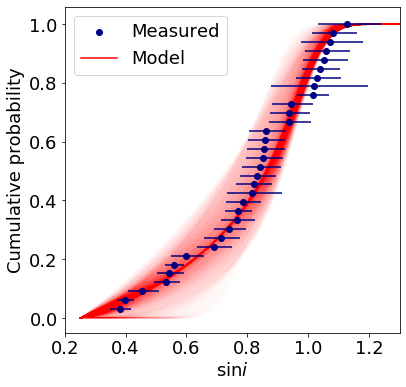

In [110]:
plt.rcParams['font.size']=18
ecdffig,ax = plt.subplots(figsize=(6,6))
#ecdffig = plt.figure(figsize=(7,7))
#ecdf = emp.ECDF(sini_new)
ecdf = emp.ECDF(joined_finalresultstbl2['bayes_sini'])

model_sini = obs_sini_distrib_uncerts(ecdf.x[1:],54,87,cutoff=0.25,n=50000)
model_sini_ecdf = emp.ECDF(model_sini)
#ecdf = emp.ECDF(joined_finalresultstbl2[:-1]['bayes_sini'])
model_sini_points = obs_sini_distrib_uncerts_specific(ecdf.x[1:],54,87,cutoff=0.25)


#model_sini_points = obs_sini_distrib_uncerts(ecdf.x[1:],10,85)

ax.scatter(ecdf.x[1:],ecdf.y[1:],color='navy',label='Measured')#, $\sin i \leq 1$')
#plt.scatter(old_ecdf.x[1:],old_ecdf.y[1:],color='orange')
#plt.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Theoretical [alpha=9, lambda=75]')

#####ax.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Best-fit model',zorder=0)
ax.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Model',zorder=0)

#for i in range(len(twosigma_vals)):
#    model_sini_twosig = obs_sini_distrib_uncerts(ecdf.x[1:],twosigma_vals[i][0],twosigma_vals[i][1],cutoff=0.25,n=50000)
#    model_sini_ecdf_twosig = emp.ECDF(model_sini_twosig)
#    ax.plot(model_sini_ecdf_twosig.x[1:],model_sini_ecdf_twosig.y[1:],color='red',alpha=0.025,label='',zorder=0)

handles, lbls = ax.get_legend_handles_labels()
ax.legend((handles[1],handles[0]),(lbls[1],lbls[0]),fontsize=18,ncol=1)

ax.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl2['bayes_sini_lo_err'],joined_finalresultstbl2['bayes_sini_hi_err']),linestyle='none',color='navy')

print(len(indx_alpha))
for i in range(len(indx_alpha)):
    print(i)
    model_sini_twosig = obs_sini_distrib_uncerts(ecdf.x[1:],indx_alpha[i],indx_lamda[i],cutoff=0.25,n=50000)
    model_sini_ecdf_twosig = emp.ECDF(model_sini_twosig)
    ax.plot(model_sini_ecdf_twosig.x[1:],model_sini_ecdf_twosig.y[1:],color='red',alpha=0.005,label='',zorder=0)

#plt.plot(model_sini_ecdf2.x[1:],model_sini_ecdf2.y[1:],color='orange',label='Best-fit model: cutoff=0.0',linestyle='--')

#plt.scatter(ecdf.x[1:],model_sini_points,color='red')


#plt.plot(ecdf.x[1:],model_sini_points,color='red')

#####handles, lbls = ax.get_legend_handles_labels()
#####ax.legend((handles[1],handles[0]),(lbls[1],lbls[0]),fontsize=18,ncol=1)

#plt.legend(loc=4)
#plt.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl['comb_sini_err']),linestyle='none',color='navy')

#####ax.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl2['bayes_sini_lo_err'],joined_finalresultstbl2['bayes_sini_hi_err']),linestyle='none',color='navy')

#plt.errorbar(ecdf.x[1:],ecdf.y[1:],yerr=ecdf.y[-1]-ecdf.y[-2],xerr=(joined_finalresultstbl['bayes_sini_hi_err']+joined_finalresultstbl['bayes_sini_lo_err'])/2,linestyle='none',color='navy')
ax.set_xlabel('$\sin i$')
ax.set_ylabel('Cumulative probability')
ax.set_xlim(0.2,1.3)
#ecdffig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/ecdffig_smaller_cdips_33.pdf',bbox_inches='tight')
ecdffig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/ecdffig_smaller_cdips_33_2sigma_smooth.pdf',bbox_inches='tight')
#plt.ylim(-.05,1.12)


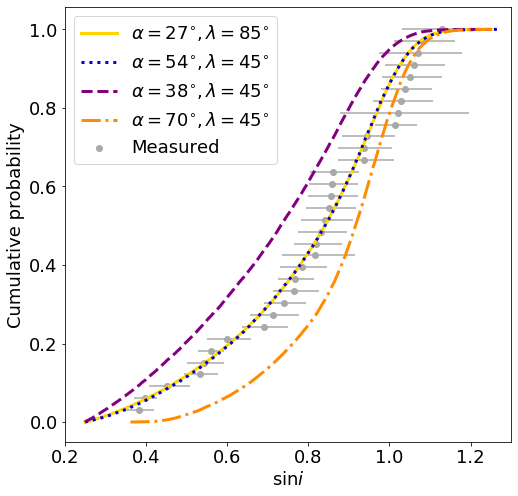

In [282]:
plt.rcParams['font.size']=18
ecdffig,ax = plt.subplots(figsize=(8,8))
#ecdffig = plt.figure(figsize=(7,7))
#ecdf = emp.ECDF(sini_new)
ecdf = emp.ECDF(joined_finalresultstbl2['bayes_sini'])
#85 27 45 54
model_sini = obs_sini_distrib_uncerts(ecdf.x[1:],27,85,cutoff=0.25,n=50000)
#model_sini = obs_sini_distrib_uncerts(ecdf.x[1:],75,90,cutoff=0.25,n=50000)
model_sini_ecdf = emp.ECDF(model_sini)
#ecdf = emp.ECDF(joined_finalresultstbl2[:-1]['bayes_sini'])
model_sini_points = obs_sini_distrib_uncerts_specific(ecdf.x[1:],54,87,cutoff=0.25)

model_sini_2 = obs_sini_distrib_uncerts(ecdf.x[1:],54,45,cutoff=0.25,n=50000)
model_sini_ecdf_2 = emp.ECDF(model_sini_2)
#ecdf = emp.ECDF(joined_finalresultstbl2[:-1]['bayes_sini'])
model_sini_points_2 = obs_sini_distrib_uncerts_specific(ecdf.x[1:],54,45,cutoff=0.25)

model_sini_3 = obs_sini_distrib_uncerts(ecdf.x[1:],38,45,cutoff=0.25,n=50000)
model_sini_ecdf_3 = emp.ECDF(model_sini_3)
#ecdf = emp.ECDF(joined_finalresultstbl2[:-1]['bayes_sini'])
model_sini_points_3 = obs_sini_distrib_uncerts_specific(ecdf.x[1:],38,45,cutoff=0.25)

model_sini_4 = obs_sini_distrib_uncerts(ecdf.x[1:],70,45,cutoff=0.25,n=50000)
model_sini_ecdf_4 = emp.ECDF(model_sini_4)
#ecdf = emp.ECDF(joined_finalresultstbl2[:-1]['bayes_sini'])
model_sini_points_4 = obs_sini_distrib_uncerts_specific(ecdf.x[1:],70,45,cutoff=0.25)

model_sini_5 = obs_sini_distrib_uncerts(ecdf.x[1:],15,90,cutoff=0.25,n=50000)
model_sini_ecdf_5 = emp.ECDF(model_sini_5)
#ecdf = emp.ECDF(joined_finalresultstbl2[:-1]['bayes_sini'])
model_sini_points_5 = obs_sini_distrib_uncerts_specific(ecdf.x[1:],15,87,cutoff=0.25)

#model_sini_points = obs_sini_distrib_uncerts(ecdf.x[1:],10,85)

ax.scatter(ecdf.x[1:],ecdf.y[1:],color='darkgray',label='Measured',alpha=1)#, $\sin i \leq 1$')
#plt.scatter(old_ecdf.x[1:],old_ecdf.y[1:],color='orange')
#plt.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Theoretical [alpha=9, lambda=75]')

#####ax.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Best-fit model',zorder=0)
ax.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='gold',label=r'$\alpha = 27^{\circ}, \lambda = 85^{\circ}$',zorder=2,linewidth=3)
#ax.plot(np.concatenate(([0],model_sini_ecdf.x[1:],[3])),np.concatenate(([0],model_sini_ecdf.y[1:],[1])),color='red',label=r'$\alpha = 54^{\circ}, \lambda = 87^{\circ}$',zorder=2,linewidth=2)
ax.plot(model_sini_ecdf_2.x[1:],model_sini_ecdf_2.y[1:],color='mediumblue',label=r'$\alpha = 54^{\circ}, \lambda = 45^{\circ}$',zorder=2,linestyle='dotted',linewidth=3)
ax.plot(model_sini_ecdf_3.x[1:],model_sini_ecdf_3.y[1:],color='purple',label=r'$\alpha = 38^{\circ}, \lambda = 45^{\circ}$',zorder=2,linestyle='--',linewidth=3)
ax.plot(model_sini_ecdf_4.x[1:],model_sini_ecdf_4.y[1:],color='darkorange',label=r'$\alpha = 70^{\circ}, \lambda = 45^{\circ}$',zorder=2,linestyle='-.',linewidth=3)
#ax.plot(model_sini_ecdf_5.x[1:],model_sini_ecdf_5.y[1:],color='darkorange',label=r'$\alpha = 70^{\circ}, \lambda = 45^{\circ}$',zorder=2,linestyle='-.',linewidth=2)


#for i in range(len(twosigma_vals)):
#    model_sini_twosig = obs_sini_distrib_uncerts(ecdf.x[1:],twosigma_vals[i][0],twosigma_vals[i][1],cutoff=0.25,n=50000)
#    model_sini_ecdf_twosig = emp.ECDF(model_sini_twosig)
#    ax.plot(model_sini_ecdf_twosig.x[1:],model_sini_ecdf_twosig.y[1:],color='red',alpha=0.025,label='',zorder=0)

###handles, lbls = ax.get_legend_handles_labels()
###ax.legend((handles[1],handles[0]),(lbls[1],lbls[0]),fontsize=18,ncol=1)
ax.legend()

ax.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl2['bayes_sini_lo_err'],joined_finalresultstbl2['bayes_sini_hi_err']),linestyle='none',color='darkgray',alpha=1)

#plt.plot(model_sini_ecdf2.x[1:],model_sini_ecdf2.y[1:],color='orange',label='Best-fit model: cutoff=0.0',linestyle='--')

#plt.scatter(ecdf.x[1:],model_sini_points,color='red')


#plt.plot(ecdf.x[1:],model_sini_points,color='red')

#####handles, lbls = ax.get_legend_handles_labels()
#####ax.legend((handles[1],handles[0]),(lbls[1],lbls[0]),fontsize=18,ncol=1)

#plt.legend(loc=4)
#plt.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl['comb_sini_err']),linestyle='none',color='navy')

#####ax.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl2['bayes_sini_lo_err'],joined_finalresultstbl2['bayes_sini_hi_err']),linestyle='none',color='navy')

#plt.errorbar(ecdf.x[1:],ecdf.y[1:],yerr=ecdf.y[-1]-ecdf.y[-2],xerr=(joined_finalresultstbl['bayes_sini_hi_err']+joined_finalresultstbl['bayes_sini_lo_err'])/2,linestyle='none',color='navy')
ax.set_xlabel('$\sin i$')
ax.set_ylabel('Cumulative probability')
###ax.set_xlim(0.2,1.3)
ax.set_xlim(0.2,1.3)

#ecdffig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/ecdffig_smaller_cdips_33.pdf',bbox_inches='tight')
ecdffig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/ecdffig_multi.pdf',bbox_inches='tight')
#plt.ylim(-.05,1.12)


In [100]:
np.meshgrid(alpha_vec,lamda_vec)[0][indx[1]][indx[0]].shape

(3775, 91)

In [101]:
indx = np.where(likelihood >= 0.05*np.max(likelihood))


In [106]:
indx_alpha = indx[1]
indx_lamda = indx[0]

In [97]:
indx[1][0],indx[0][0]

(55, 11)

In [102]:
indx[1][0:20]

array([55, 56, 54, 55, 56, 57, 54, 55, 56, 57, 58, 53, 54, 55, 56, 57, 58,
       53, 54, 55])

In [103]:
indx[0][0:20]

array([11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14,
       15, 15, 15])

In [104]:
for i in range(len(alpha_vec)):
    for j in range(len(twosigma_vals)):
        if 

SyntaxError: invalid syntax (<ipython-input-104-0b1c763a9b1e>, line 3)

In [ ]:
np.argmax(joined_finalresultstbl2['bayes_sini_hi_err'])

In [481]:
joined_finalresultstbl2[-7]

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,Cluster,Object,Icmag,Jmag,Hmag,Kmag,S/N,RV,vsini,logTeff,Nsp,pRV,pvsini,gaia_r,parallax_err,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,survey,sobject_id,field_id,raj2000,dej2000,jmag,hmag,kmag,vmag_jk,e_jmag,e_hmag,e_kmag,snr_c1,snr_c2,snr_c3,snr_c4,rv_synt,e_rv_synt,rv_obst,e_rv_obst,rv_nogr_obst,e_rv_nogr_obst,chi2_cannon,sp_label_distance,flag_cannon,teff,e_teff,logg,e_logg,fe_h,e_fe_h,vmic,e_vmic,e_vsini,alpha_fe,e_alpha_fe,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,y_fe,e_y_fe,flag_y_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,eu_fe,e_eu_fe,flag_eu_fe,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,exofast_r,r_hi_err,r_lo_err,exofast_teff,teff_hi_err,teff_lo_err,star_id,ndfclass,period,e_period,bayes_sini,bayes_sini_lo_err,bayes_sini_hi_err
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str7,str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str8,float64,float64,float64,float64,str5,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,str16,str8,float64,float64,float64,float64,float64
119.62662452597256,-61.168576005207235,5290653075858442752,274.22422386291186,-16.00070990601393,2.4852013772353576,0.024379217565162793,-4.110094823056237,0.04852623351704215,10.788076314657793,0.040559134161769386,0.17108783,0.22939928,-0.18688472,0.03279104,0.34856045,0.12190557,-0.2079526,0.19214812,-0.09254736,0.06974314,386,15.026208,1.4376688,0.800000011920929,NGC2516,07583040-6110071,0.0,13.21,12.62,12.5,10.67,26.57,75.0,3.619,2,4.03,0.12,0.6558167338371277,0.024379217565162793,NGC_2516,-1.0376973,175.54398999999998,0.0,0.0,GES,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,4159.106104940223,389.79438659233585,--,--,--,--,--,--,9.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.10416861856356263,0.0,0.00833348948508501,1,C,0.703,0.019,0.018000000000000002,4520.0,150.0,150.0,--,--,0.4744010329113474,0.008333267830312251,1.0205102551275638,0.1410705352676339,0.17508754377188596


In [488]:
joined_finalresultstbl2[-1]

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,Cluster,Object,Icmag,Jmag,Hmag,Kmag,S/N,RV,vsini,logTeff,Nsp,pRV,pvsini,gaia_r,parallax_err,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,survey,sobject_id,field_id,raj2000,dej2000,jmag,hmag,kmag,vmag_jk,e_jmag,e_hmag,e_kmag,snr_c1,snr_c2,snr_c3,snr_c4,rv_synt,e_rv_synt,rv_obst,e_rv_obst,rv_nogr_obst,e_rv_nogr_obst,chi2_cannon,sp_label_distance,flag_cannon,teff,e_teff,logg,e_logg,fe_h,e_fe_h,vmic,e_vmic,e_vsini,alpha_fe,e_alpha_fe,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,y_fe,e_y_fe,flag_y_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,eu_fe,e_eu_fe,flag_eu_fe,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,exofast_r,r_hi_err,r_lo_err,exofast_teff,teff_hi_err,teff_lo_err,star_id,ndfclass,period,e_period,bayes_sini,bayes_sini_lo_err,bayes_sini_hi_err
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str7,str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str8,float64,float64,float64,float64,str5,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,str16,str8,float64,float64,float64,float64,float64
119.25998129356094,-61.03465617585395,5290664929967787264,274.0156045458683,-16.096273101399444,2.423858840447574,0.02465442465699191,-4.249929974106201,0.04965415719118762,11.316085418448882,0.043708430181997646,-0.1828444,-0.11409408,-0.44087377,0.19312134,0.33971387,0.27938685,-0.2737395,0.29234594,-0.10523812,-0.1598389,319,11.817455,0.7374668,1.0,NGC2516,07570240-6102049,0.0,10.86,10.64,10.53,183.42,25.16,50.0,3.808,2,0.38,0.05,1.3395180702209473,0.02465442465699191,NGC_2516,3.2343655,238.40315,0.0,0.0,GES,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,6426.877173170194,35.039129719606336,--,--,--,--,--,--,2.5,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.37500690948218107,0.0264466875287171,0.05387641159076604,1,C,1.375,0.03,0.03,6490.0,130.0,130.0,--,--,1.4166638273745775,0.38541589421220124,1.167583791895948,0.2881440720360181,0.417208604302151


In [238]:

joined_finalresultstbl['source_id','bayes_sini'].write('/Users/bhealy/Downloads/verifythese.txt',format='ascii')

In [580]:
joined_finalresultstbl2

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,Cluster,Object,Icmag,Jmag,Hmag,Kmag,S/N,RV,vsini,logTeff,Nsp,pRV,pvsini,gaia_r,parallax_err,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,survey,sobject_id,field_id,raj2000,dej2000,jmag,hmag,kmag,vmag_jk,e_jmag,e_hmag,e_kmag,snr_c1,snr_c2,snr_c3,snr_c4,rv_synt,e_rv_synt,rv_obst,e_rv_obst,rv_nogr_obst,e_rv_nogr_obst,chi2_cannon,sp_label_distance,flag_cannon,teff,e_teff,logg,e_logg,fe_h,e_fe_h,vmic,e_vmic,e_vsini,alpha_fe,e_alpha_fe,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,y_fe,e_y_fe,flag_y_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,eu_fe,e_eu_fe,flag_eu_fe,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,exofast_r,r_hi_err,r_lo_err,exofast_teff,teff_hi_err,teff_lo_err,star_id,ndfclass,period,e_period,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_g_mean_flux_over_error,e_bp_rp,e_gmag,bayes_sini,bayes_sini_lo_err,bayes_sini_hi_err
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str7,str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str8,float64,float64,float64,float64,str5,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,str16,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
118.96424957852149,-60.9670225989847,5290715919819356800,273.88477447001804,-16.19289637953639,2.4116537829791986,0.03461708719397074,-4.447843575372962,0.07491290936048897,10.997788913428714,0.06566002678822505,-0.036261998,-0.10274949,-0.13393322,0.11895334,0.28956938,0.18289489,-0.33514327,0.18048467,-0.0056276266,0.0080021275,416,16.025776,1.8827343,0.699999988079071,NGC2516,07555144-6058015,0.0,13.8,13.02,12.81,64.16,23.4,55.2,3.634,4,0.47,0.04,0.7077617645263672,0.03461708719397074,NGC_2516,1.5641948,267.69177,0.11276155360300345,0.8914978971218483,GES,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,4305.266104917106,67.10202781978033,--,--,--,--,--,--,2.208,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.04166742414236069,0.0,0.008333484828472138,1,C,0.637,0.027000000000000003,0.031,4290.0,210.0,210.0,--,--,0.2214280855708888,0.010206184867177571,194.72037,510.5224,1045.8955,0.005951346456465483,0.0010375

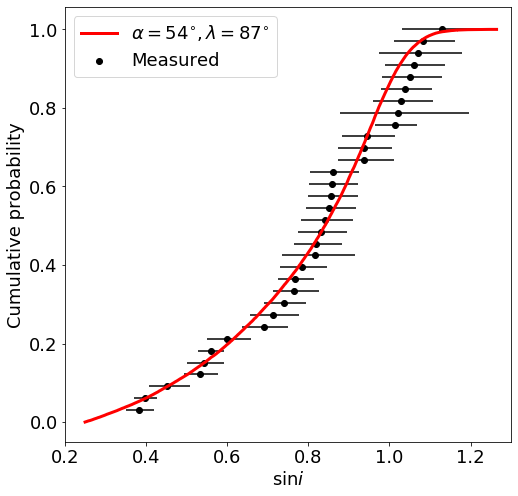

In [273]:
plt.rcParams['font.size']=18
ecdffig = plt.figure(figsize=(8,8))
#ecdf = emp.ECDF(sini_new)
#ecdf = emp.ECDF(joined_finalresultstbl['bayes_sini'])
ecdf = emp.ECDF(finalresults['bayes_sini'])


#model_sini_points = obs_sini_distrib_uncerts(ecdf.x[1:],10,85)

plt.scatter(ecdf.x[1:],ecdf.y[1:],color='black',label='Measured')#, $\sin i \leq 1$')
#plt.scatter(old_ecdf.x[1:],old_ecdf.y[1:],color='orange')
#plt.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label='Theoretical [alpha=9, lambda=75]')
plt.plot(model_sini_ecdf.x[1:],model_sini_ecdf.y[1:],color='red',label=r'$\alpha = 54^{\circ}, \lambda = 87^{\circ}$',linewidth=3)
#plt.plot(model_sini_ecdf2.x[1:],model_sini_ecdf2.y[1:],color='orange',label='Best-fit model: cutoff=0.0',linestyle='--')

#plt.scatter(ecdf.x[1:],model_sini_points,color='red')


#plt.plot(ecdf.x[1:],model_sini_points,color='red')
plt.legend()
#plt.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl['comb_sini_err']),linestyle='none',color='navy')
#plt.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(joined_finalresultstbl['bayes_sini_lo_err'],joined_finalresultstbl['bayes_sini_hi_err']),linestyle='none',color='navy')
plt.errorbar(ecdf.x[1:],ecdf.y[1:],xerr=(finalresults['bayes_sini_lo_err'],finalresults['bayes_sini_hi_err']),linestyle='none',color='black')


#plt.errorbar(ecdf.x[1:],ecdf.y[1:],yerr=ecdf.y[-1]-ecdf.y[-2],xerr=(joined_finalresultstbl['bayes_sini_hi_err']+joined_finalresultstbl['bayes_sini_lo_err'])/2,linestyle='none',color='navy')
plt.xlabel('$\sin i$')
plt.ylabel('Cumulative probability')
plt.xlim(0.2,1.3)
ecdffig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/ecdffig_black.pdf',bbox_inches='tight')



In [146]:
Table(data=[ecdf.x[1:],ecdf.y[1:],joined_finalresultstbl['bayes_sini_hi_err'],joined_finalresultstbl['bayes_sini_lo_err']],names=['data_ecdf_x','data_ecdf_y','e_sini_upper','e_sini_lower']).write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig7/fig7_ecdf_33_cdips.txt',format='ascii')




In [147]:
Table(data=[model_sini_ecdf.x[1:],model_sini_ecdf.y[1:]],names=['model_x','model_y']).write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig7/fig7_model_sini.txt',format='ascii')


In [1461]:
joined_finalresultstbl[-9]['period','period_unc','source_id','bayes_sini','bayes_sini_hi_err','vsini']

period,period_unc,source_id,bayes_sini,bayes_sini_hi_err,vsini
float64,float64,int64,float64,float64,float64
0.4738185278931008,0.0041667458483061635,5290653075858442752,1.0026677785190126,0.1741160773849233,75.0


In [1320]:
np.median(V),np.std(V),np.min(V),np.max(V)

(24.372976931461338, 19.85116744989394, 11.214713253235738, 84.478240068379)

In [1248]:
np.mean(joined_finalresultstbl['bayes_sini'])

0.8316121888951609

In [1253]:
joined_finalresultstbl['source_id','phot_g_mean_mag','teff','vsini','e_vsini','pvsini','period','period_unc','exofast_r','r_hi_err','bayes_sini','bayes_sini_hi_err'][14:25]


source_id,phot_g_mean_mag,teff,vsini,e_vsini,pvsini,period,period_unc,exofast_r,r_hi_err,bayes_sini,bayes_sini_hi_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5290725231308404864,12.523628,6123.503917247734,19.2,0.96,0.05,2.436903344902293,0.06870920379720025,1.124,0.026000000000000002,0.8273861541027352,0.06220624082721815
5290728834785867264,12.838233,5997.910762555094,15.0,0.75,0.05,2.9321962631054177,0.00833348511641816,1.047,0.021,0.8346749132755171,0.060921484322881914
5290710800218328192,12.968279,6067.363295885053,12.2,0.976,0.08,3.7078060751805544,0.1603245081838917,1.054,0.021,0.8564491894596398,0.08217589392928626
5290739937276199168,14.352622,4226.686142656029,35.2,1.7600000000000002,0.05,0.9791847333660825,0.0,0.799,0.019,0.8570660106737827,0.06354706470980642
5290725781064133760,13.151804,5794.286964268809,13.1,0.655,0.05,3.186307957941146,0.11451534997296478,0.966,0.023,0.8587396764509674,0.06387473315543701
5290723204083832448,12.311568,6280.58358813318,32.8,1.64,0.05,1.598243835082972,0.045807009409701616,1.207,0.026000000000000002,0.862768242161441,0.06384883589059376
5290838962037067648,12.003408,6382.634861905489,68.0,3.4000000000000004,0.05,0.8124902607412421,0.0,1.26,0.024,0.8682248498999334,0.06639756504336214
5290770345645486976,12.430677,6397.348354826482,21.9,1.095,0.05,2.3958327520290363,0.022903075692994282,1.193,0.024,0.8738580553702469,0.06376636090727161
5290823568880135296,12.724019,6067.363295885053,19.1,0.5730000000000001,0.03,2.5187790367409213,0.0647804430433021,1.092,0.026000000000000002,0.874305863909273,0.055313215476984534


In [1245]:
np.mean(finalresults['phot_g_mean_mag']), np.std(finalresults['phot_g_mean_mag'])

(13.00835982051282, 0.971010306640483)

(array([9., 8., 8., 3., 4., 3., 0., 0., 2., 2.]),
 array([ 5.1 , 12.09, 19.08, 26.07, 33.06, 40.05, 47.04, 54.03, 61.02,
        68.01, 75.  ]),
 <a list of 10 Patch objects>)

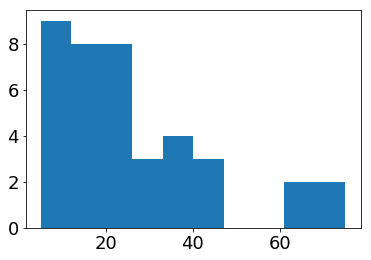

In [1095]:
plt.hist(finalresults['vsini'])

(array([3., 3., 4., 5., 4., 6., 2., 7., 3., 2.]),
 array([0.39047597, 0.77096016, 1.15144435, 1.53192855, 1.91241274,
        2.29289693, 2.67338112, 3.05386531, 3.4343495 , 3.81483369,
        4.19531788]),
 <a list of 10 Patch objects>)

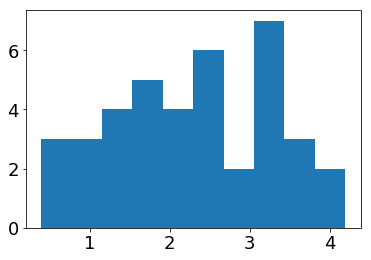

In [1096]:
plt.hist(finalresults['period'])

(array([ 3.,  3.,  1.,  4., 12.,  5.,  6.,  3.,  1.,  1.]),
 array([0.648 , 0.7336, 0.8192, 0.9048, 0.9904, 1.076 , 1.1616, 1.2472,
        1.3328, 1.4184, 1.504 ]),
 <a list of 10 Patch objects>)

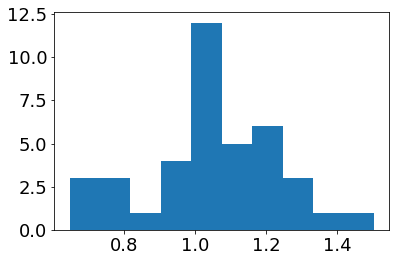

In [1098]:
plt.hist(finalresults['exofast_r'])

In [1011]:
model_sini_points = obs_sini_distrib_uncerts_specific(ecdf.x[1:],20,89)
model_sini_points

array([0.00422097, 0.07911323, 0.08809208, 0.10941404, 0.11989058,
       0.15582921, 0.1639179 , 0.17076411, 0.17673342, 0.22909264,
       0.28348813, 0.31878141, 0.33247437, 0.34735387, 0.34796657,
       0.36160629, 0.39708471, 0.44838729, 0.45685307, 0.49486765,
       0.50206474, 0.5048721 , 0.50924119, 0.51450465, 0.52725144,
       0.53095986, 0.58933811, 0.6171444 , 0.69504644, 0.73057455,
       0.75205869, 0.80612645, 0.83791972, 0.8433226 , 0.91393167,
       0.91494927, 0.93906612, 0.96267923, 0.96744146, 0.97217868,
       0.97473995, 0.97853339])

In [1012]:
ecdf.y[1:]

array([0.02380952, 0.04761905, 0.07142857, 0.0952381 , 0.11904762,
       0.14285714, 0.16666667, 0.19047619, 0.21428571, 0.23809524,
       0.26190476, 0.28571429, 0.30952381, 0.33333333, 0.35714286,
       0.38095238, 0.4047619 , 0.42857143, 0.45238095, 0.47619048,
       0.5       , 0.52380952, 0.54761905, 0.57142857, 0.5952381 ,
       0.61904762, 0.64285714, 0.66666667, 0.69047619, 0.71428571,
       0.73809524, 0.76190476, 0.78571429, 0.80952381, 0.83333333,
       0.85714286, 0.88095238, 0.9047619 , 0.92857143, 0.95238095,
       0.97619048, 1.        ])

0.08685019925967996


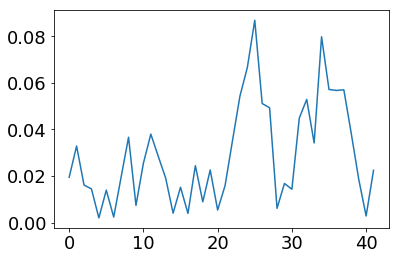

In [1006]:
plt.plot(np.abs(ecdf.y[1:]-model_sini_points))
print(np.max(np.abs(np.sort(ecdf.y[1:])-np.sort(model_sini_points))))

In [1010]:
ks_2samp(ecdf.y[1:],obs_sini_distrib_uncerts_specific(ecdf.x[1:],20,89),mode='exact')

Ks_2sampResult(statistic=0.09523809523809523, pvalue=0.9925500877766478)

In [1013]:
ks_2samp(ecdf.y[1:],model_sini_points,mode='exact')

Ks_2sampResult(statistic=0.09523809523809523, pvalue=0.9925500877766478)

In [835]:
model_sini_points

array([2.00000000e-05, 6.79419226e-02, 7.64151777e-02, 1.00050055e-01,
       1.12116423e-01, 1.52519446e-01, 1.61460390e-01, 1.69150474e-01,
       1.75634456e-01, 2.34379455e-01, 2.95014513e-01, 3.33737598e-01,
       3.48718976e-01, 3.63971219e-01, 3.64608643e-01, 3.77941484e-01,
       4.14119542e-01, 4.65103443e-01, 4.73478067e-01, 5.11166776e-01,
       5.18285283e-01, 5.20809292e-01, 5.24874575e-01, 5.29714994e-01,
       5.41388927e-01, 5.45588105e-01, 6.01902610e-01, 6.27051848e-01,
       7.00904762e-01, 7.32524484e-01, 7.53798534e-01, 8.06539230e-01,
       8.36926235e-01, 8.42381674e-01, 9.10901937e-01, 9.11682039e-01,
       9.36167283e-01, 9.60716349e-01, 9.66237703e-01, 9.70754875e-01,
       9.73320866e-01, 9.77289770e-01])

In [830]:
ecdf.x[1:]

array([0.0889985 , 0.38635385, 0.40400151, 0.44776504, 0.46859445,
       0.52937417, 0.54127814, 0.55109   , 0.56019334, 0.62937914,
       0.69015977, 0.72485946, 0.73706706, 0.74917476, 0.74967527,
       0.76049247, 0.78783727, 0.82284082, 0.82838233, 0.85040956,
       0.8542047 , 0.85567159, 0.85825874, 0.86082792, 0.86728485,
       0.86925542, 0.89657752, 0.90779047, 0.93754956, 0.9495857 ,
       0.95719388, 0.97638998, 0.98783705, 0.98990628, 1.02042305,
       1.02091629, 1.03507524, 1.05293999, 1.05790359, 1.06270426,
       1.06553681, 1.07066086])

In [921]:
ks_2samp(ecdf.y[1:],model_sini_points,mode='exact')

Ks_2sampResult(statistic=0.09523809523809523, pvalue=0.9925500877766478)

In [1022]:
model_sini_points = obs_sini_distrib_uncerts_specific(ecdf.x[1:],54,47)

In [1015]:
anderson_ksamp((ecdf.y[1:],model_sini_points))

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: p-value capped: true value larger than 0.25
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=-1.0427630047582546, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

In [1023]:
anderson_ksamp((ecdf.y[1:],model_sini_points))

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: p-value capped: true value larger than 0.25
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=-1.0658127093719512, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

In [782]:
joined_finalresultstbl.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/joined_finalresultstbl42.dat',format='ascii')

In [126]:
np.mean(joined_finalresultstbl2['bayes_sini_hi_err']/joined_finalresultstbl2['bayes_sini'])

0.08390992010337284

In [127]:
np.mean(joined_finalresultstbl2['e_vsini']/joined_finalresultstbl2['vsini'])

0.05242424242424243

In [128]:
np.mean(joined_finalresultstbl2['e_period']/joined_finalresultstbl2['period'])

0.018429260417175873

In [129]:
np.mean(joined_finalresultstbl2['r_hi_err']/joined_finalresultstbl2['exofast_r'])

0.023231480294806244

In [520]:
np.mean(np.max())

0.0020000000000000018

In [ ]:
np.max(joined_finalresultstbl['r_hi_err'],joined_finalresultstbl['r_lo_err'])

In [106]:
np.arange(0.25,0.35,0.05)

array([0.25, 0.3 ])

In [62]:
ecdf_sim = emp.ECDF(rand_sini_100)

In [373]:
joined_finalresultstbl2['bayes_sini'].data

array([0.3821911 , 0.3971986 , 0.45322661, 0.53326663, 0.54427214,
       0.55927964, 0.59929965, 0.69034517, 0.71235618, 0.74037019,
       0.76538269, 0.76838419, 0.7853927 , 0.8164082 , 0.82041021,
       0.83141571, 0.84242121, 0.85242621, 0.85642821, 0.85942971,
       0.86043022, 0.93646823, 0.93646823, 0.94447224, 1.01450725,
       1.02051026, 1.02951476, 1.03951976, 1.05152576, 1.05952976,
       1.07053527, 1.08254127, 1.12856428])

In [15]:
alpha_vec = np.arange(0,91,1)
lamda_vec = np.arange(0,91,1)

In [585]:
#list_ecdf = [rand_sini_10,rand_sini_30,rand_sini_100,
#            lowalign_10,lowalign_30,lowalign_100,
#            medalign_10,medalign_30,medalign_100]

list_ecdf = [joined_finalresultstbl2['bayes_sini'].data,
            rand_sini_30,
            lowalign_30,
            medalign_30]

import sys
eps = sys.float_info.epsilon
eps=0

alpha_vec = np.arange(0+eps,91-eps,1)
lamda_vec = np.arange(0+eps,91-eps,1)
#tau_vec = np.arange(0.25,0.35,0.05)

#chi2 = np.zeros((len(alpha_vec),len(lamda_vec)))
chi2 = np.zeros((len(alpha_vec),len(lamda_vec),len(list_ecdf)))

ksprob = np.copy(chi2)
###err = (joined_finalresultstbl2['bayes_sini_lo_err']+joined_finalresultstbl2['bayes_sini_hi_err'])/2


###incempx1 = ecdf.x[1:]
###incempy1 = ecdf.y[1:]

#####incempx1 = ecdf_sim.x[1:]
#####incempy1 = ecdf_sim.y[1:]
#####err = 0.08 * ecdf_sim.x[1:]

for k in range(len(list_ecdf)):
    print(k)
    ecdf_sim = emp.ECDF(list_ecdf[k])
    incempx1 = ecdf_sim.x[1:]
    incempy1 = ecdf_sim.y[1:]
    #err = 0.08 * ecdf_sim.x[1:]
    err = 0.1 * ecdf_sim.x[1:]

    for i in range(len(alpha_vec)):
        for j in range(len(lamda_vec)):

        #for k in range(len(tau_vec)):
        #print(alpha_vec[i],lamda_vec[j])
        #try:
        
            #chi2[j,i,k] = np.sum((incempy1 - obs_sini_distrib_specific(incempx1,alpha_vec[i],lamda_vec[j],cutoff=0.25,n=5000))**2 / err**2)
            chi2[j,i,k] = np.sum((incempy1 - obs_sini_distrib_uncerts_specific(incempx1,alpha_vec[i],lamda_vec[j],cutoff=0.25,n=5000))**2 / err**2)

            #chi2[j,i,k] = np.sum((incempy1 - obs_sini_distrib_specific(incempx1,alpha_vec[i],lamda_vec[j],cutoff=tau_vec[k],n=50000))**2 / err**2)

        #chi2[j,i] = np.sum((incempy1+1 - obs_sini_distrib_specific(incempx1,alpha_vec[i],lamda_vec[j])+1)**2 / (obs_sini_distrib_specific(incempx1,alpha_vec[i],lamda_vec[j])+1))

        #####ksprob[j,i] = ks_2samp(incempy1,obs_sini_distrib_uncerts_specific(incempx1,alpha_vec[i],lamda_vec[j],cutoff=0.25,n=5000))[1]
            #ksprob[j,i,k] = ks_2samp(incempy1,obs_sini_distrib_uncerts_specific(incempx1,alpha_vec[i],lamda_vec[j],cutoff=tau_vec[k]))[1]

        ###chi2[j,i] = np.sum((incempy1 - (obs_sini_distrib_uncerts_specific(incempx1,alpha_vec[i],lamda_vec[j])))**2 / (obs_sini_distrib_uncerts_specific(incempx1,alpha_vec[i],lamda_vec[j])))

        #except ZeroDivisionError:
        #    chi2[j,i] = np.ma.masked
            
            
            
reduced_chi2 = chi2 / (len(err)-2)
likelihood = np.exp(-reduced_chi2/2)       

0


/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


1
2
3


In [30]:
alpha_vec = np.arange(0,91,1)
lamda_vec = np.arange(0,91,1)

chi2 = np.zeros((len(alpha_vec),len(lamda_vec)))

incempx1 = ecdf.x[1:]
incempy1 = ecdf.y[1:]
err = (joined_finalresultstbl2['bayes_sini_lo_err']+joined_finalresultstbl2['bayes_sini_hi_err'])/2

for i in range(len(alpha_vec)):
    for j in range(len(lamda_vec)):

        #for k in range(len(tau_vec)):
        #print(alpha_vec[i],lamda_vec[j])
        #try:
        
            #chi2[j,i,k] = np.sum((incempy1 - obs_sini_distrib_specific(incempx1,alpha_vec[i],lamda_vec[j],cutoff=0.25,n=5000))**2 / err**2)
        chi2[j,i] = np.sum((incempy1 - obs_sini_distrib_uncerts_specific(incempx1,alpha_vec[i],lamda_vec[j],cutoff=0.25,n=50000))**2 / err**2)

reduced_chi2 = chi2 / (len(err)-2)
likelihood = np.exp(-reduced_chi2/2) 

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [148]:
ecdf_sim

[1.0464738520749548,
 0.9673913522233933,
 0.9786888522021878,
 0.888308852371832,
 0.8318213524778596,
 0.9899863521809823,
 1.1368538519053102,
 0.9786888522021878,
 0.8431188524566541,
 0.651061352817148]

In [293]:
len(err)

10

In [31]:
reduced_chi2 = chi2 / (len(err)-2)
likelihood = np.exp(-reduced_chi2/2)

In [32]:
reduced_chi2

array([[172.69342149, 172.69342149, 172.69342149, ...,  33.84602095,
         33.89922461,  34.09070955],
       [172.69342149, 172.69342149, 172.69342149, ...,  34.03008198,
         33.98626386,  33.92131546],
       [172.69342149, 172.69342149, 172.69342149, ...,  33.90312659,
         34.07530741,  33.93288192],
       ...,
       [  0.77391586,   0.7609171 ,   0.76869603, ...,   0.87598061,
          0.87624632,   0.84743544],
       [  0.76094872,   0.76780647,   0.78207876, ...,   0.85525023,
          0.86234106,   0.82209202],
       [  0.87330496,   0.82647021,   0.83191114, ...,   0.82578341,
          0.81623397,   0.83872433]])

In [296]:
ksprob

array([[2.16501764e-04, 2.16501764e-04, 2.16501764e-04, ...,
        1.23406006e-02, 1.23406006e-02, 1.23406006e-02],
       [2.16501764e-04, 2.16501764e-04, 2.16501764e-04, ...,
        1.23406006e-02, 1.23406006e-02, 1.23406006e-02],
       [2.16501764e-04, 2.16501764e-04, 2.16501764e-04, ...,
        1.23406006e-02, 1.23406006e-02, 1.23406006e-02],
       ...,
       [9.94457555e-01, 9.94457555e-01, 9.94457555e-01, ...,
        7.86929788e-01, 7.86929788e-01, 7.86929788e-01],
       [9.94457555e-01, 9.94457555e-01, 7.86929788e-01, ...,
        7.86929788e-01, 7.86929788e-01, 7.86929788e-01],
       [7.86929788e-01, 7.86929788e-01, 9.94457555e-01, ...,
        7.86929788e-01, 7.86929788e-01, 7.86929788e-01]])

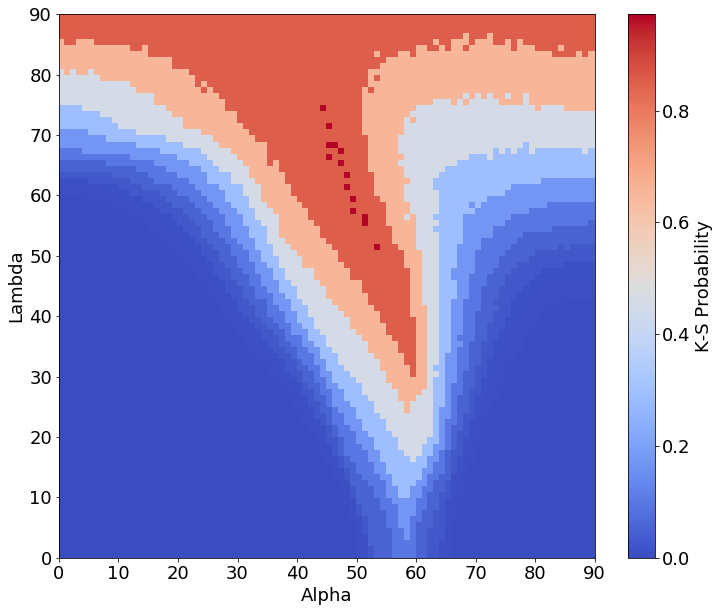

In [124]:
plt.figure(figsize=(12,10))
#plt.pcolor(alpha_vec,lamda_vec,chi2/2,cmap='coolwarm')

#plt.pcolor(alpha_vec,lamda_vec,np.exp(-chi2/2),cmap='coolwarm')#,vmin=.5,vmax=1.01)
#plt.pcolor(alpha_vec,lamda_vec,likelihood,cmap='coolwarm')#,vmin=np.min(likelihood),vmax=np.max(likelihood))

#plt.pcolor(alpha_vec,lamda_vec,np.log(chi2),cmap='coolwarm_r')
#plt.pcolor(alpha_vec,lamda_vec,chi2,cmap='coolwarm_r')

#plt.pcolor(alpha_vec,lamda_vec,ksprob[:,:,4],cmap='coolwarm')
plt.pcolor(alpha_vec,lamda_vec,ksprob,cmap='coolwarm')

plt.colorbar(label='K-S Probability')
#plt.colorbar(label='Likelihood')# $e^{-\chi^2/2}$')
#plt.colorbar(label='$\log \chi^2$')

plt.xlabel('Alpha')
plt.ylabel('Lambda')
#plt.xlim(0,20)
#plt.ylim(70,90)
plt.show()

In [ ]:
#list_ecdf = [rand_sini_10,rand_sini_30,rand_sini_100,
#            lowalign_10,lowalign_30,lowalign_100,
#            medalign_10,medalign_30,medalign_100]

0
1
2
3


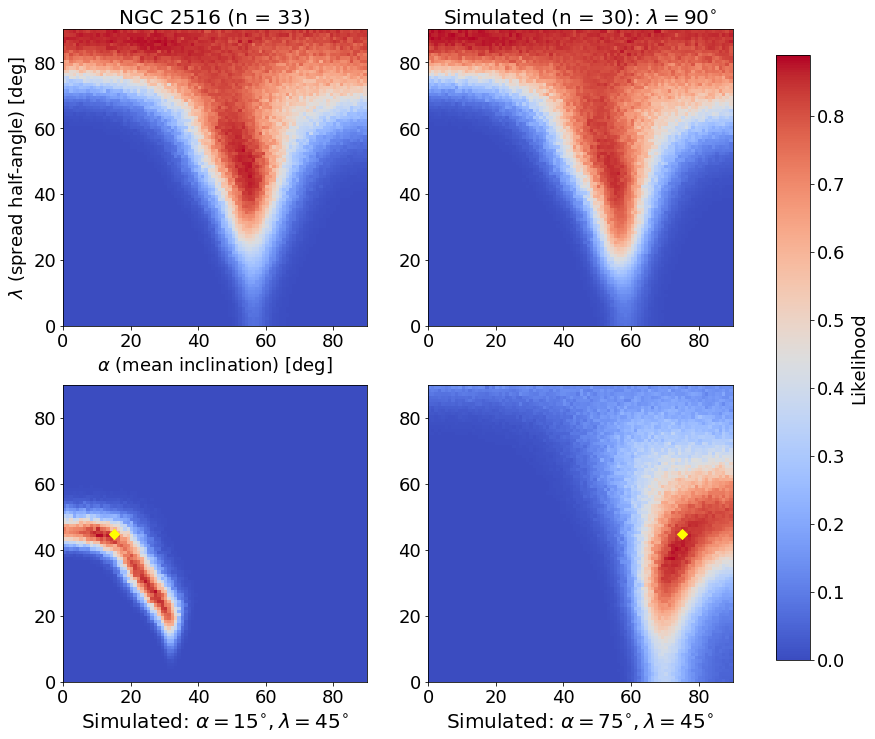

In [602]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
for i in range(2):
    for j in range(2):
        im = ax[i,j].pcolor(alpha_vec,lamda_vec,likelihood[:,:,2*i+j],cmap='coolwarm')
        print(2*i+j)
        
ax[0,0].set_xlabel(r'$\alpha$ (mean inclination) [deg]')
ax[0,0].set_ylabel(r'$\lambda$ (spread half-angle) [deg]')
ax[0,0].set_title('NGC 2516 (n = 33)',fontsize=20)
ax[0,1].set_title(r'Simulated (n = 30): $\lambda = 90^{\circ}$',fontsize=20)
ax[1,0].set_xlabel(r'Simulated: $\alpha = 15^{\circ}, \lambda = 45^{\circ}$',fontsize=20)
ax[1,1].set_xlabel(r'Simulated: $\alpha = 75^{\circ}, \lambda = 45^{\circ}$',fontsize=20)

ax[1,0].scatter([15],[45],color='yellow',marker='D',s=50)
ax[1,1].scatter([75],[45],color='yellow',marker='D',s=50)



#ax[0,1].set_title(r'$\alpha = 45^{\circ}, \lambda = 90^{\circ}$')
#ax[1,1].set_title(r'$\alpha = 25^{\circ}, \lambda = 25^{\circ}$')
#ax[2,1].set_title(r'$\alpha = 75^{\circ}, \lambda = 25^{\circ}$')

#ax[2,0].set_xlabel(r'${\rm N_{inc}} = 10$')
#ax[2,1].set_xlabel(r'${\rm N_{inc}} = 30$')
#ax[2,2].set_xlabel(r'${\rm N_{inc}} = 100$')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, .15, 0.04, .7])
fig.colorbar(im, cax=cbar_ax,label='Likelihood')

fig.savefig('/Users/bhealy/Documents/PhD_Thesis/sim_inclination_cmaps_2x2_new.pdf',bbox_inches='tight')


0
1
2
3
4
5
6
7
8


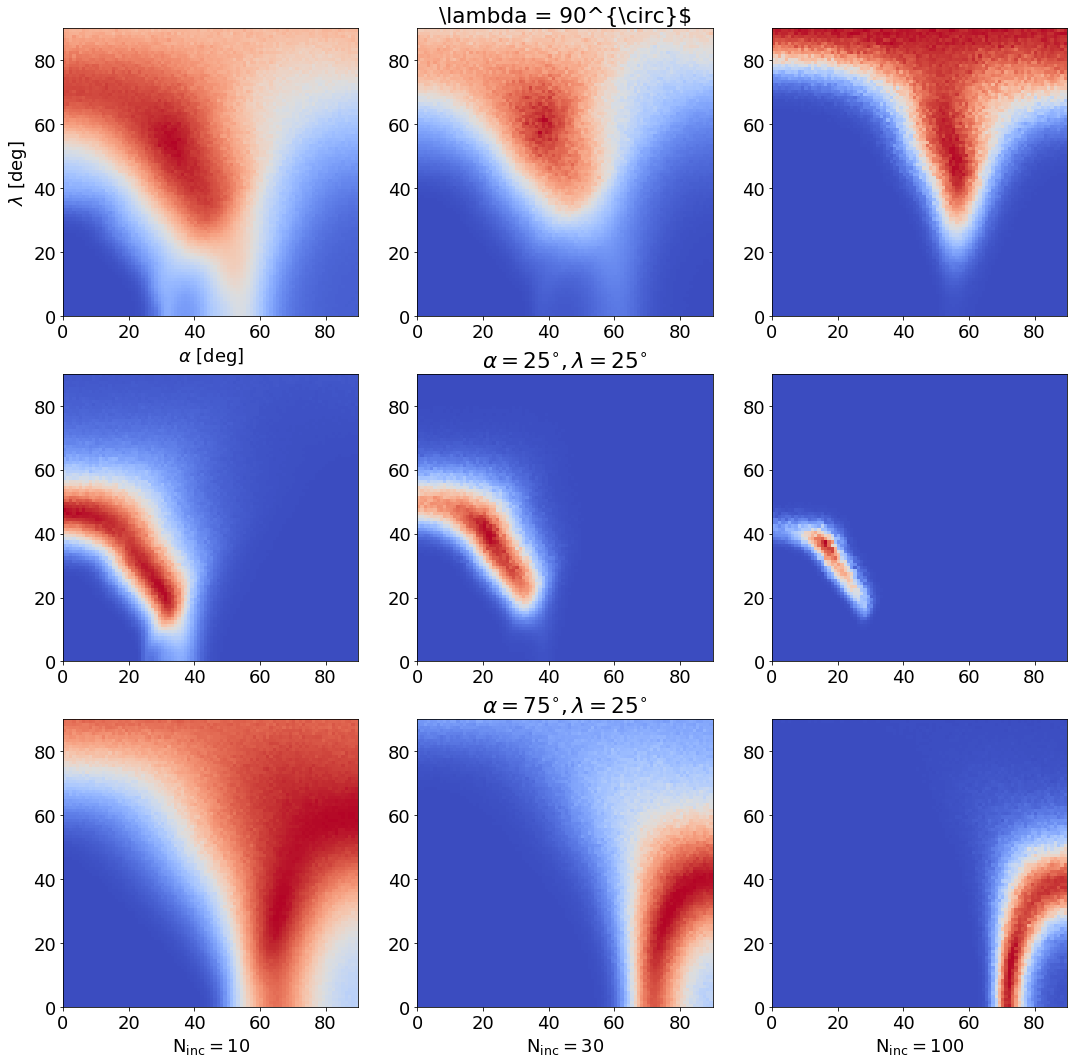

In [452]:
fig,ax = plt.subplots(3,3,figsize=(18,18))
for i in range(3):
    for j in range(3):
        ax[i,j].pcolor(alpha_vec,lamda_vec,likelihood[:,:,3*i+j],cmap='coolwarm')
        print(3*i+j)
        
ax[0,0].set_xlabel(r'$\alpha$ [deg]')
ax[0,0].set_ylabel(r'$\lambda$ [deg]')
ax[0,1].set_title(r'\lambda = 90^{\circ}$')
ax[1,1].set_title(r'$\alpha = 25^{\circ}, \lambda = 25^{\circ}$')
ax[2,1].set_title(r'$\alpha = 75^{\circ}, \lambda = 25^{\circ}$')

ax[2,0].set_xlabel(r'${\rm N_{inc}} = 10$')
ax[2,1].set_xlabel(r'${\rm N_{inc}} = 30$')
ax[2,2].set_xlabel(r'${\rm N_{inc}} = 100$')

fig.savefig('/Users/bhealy/Documents/PhD_Thesis/sim_inclination_cmaps.pdf',bbox_inches='tight')


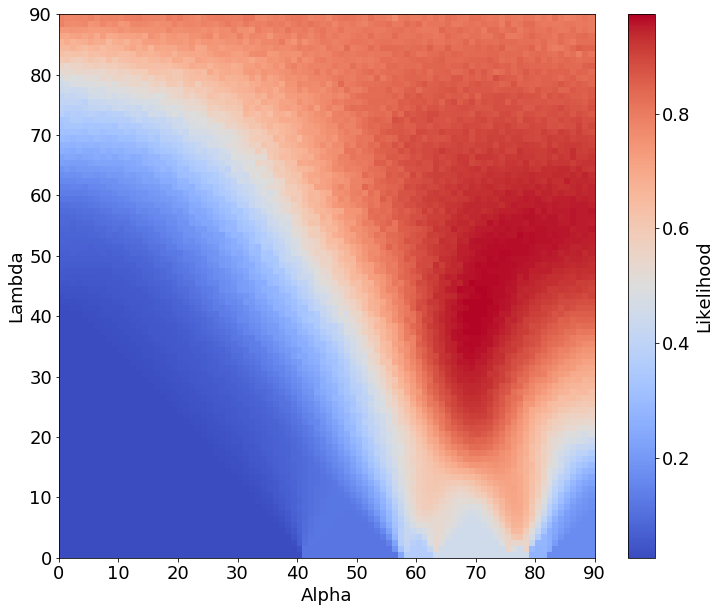

In [166]:
chifig = plt.figure(figsize=(12,10))
#plt.pcolor(alpha_vec,lamda_vec,chi2/2,cmap='coolwarm')

plt.pcolor(alpha_vec,lamda_vec,likelihood[:,:,0],cmap='coolwarm')#,vmin=.5,vmax=1.01)
#plt.pcolor(alpha_vec,lamda_vec,likelihood,cmap='coolwarm')#,vmin=np.min(likelihood),vmax=np.max(likelihood))

#plt.pcolor(alpha_vec,lamda_vec,np.log(chi2),cmap='coolwarm_r')
#plt.pcolor(alpha_vec,lamda_vec,chi2,cmap='coolwarm_r')

#plt.pcolor(alpha_vec,lamda_vec,ksprob,cmap='coolwarm')

#plt.colorbar(label='K-S Probability')
plt.colorbar(label='Likelihood')# $e^{-\chi^2/2}$')
#plt.colorbar(label='$\log \chi^2$')

plt.xlabel('Alpha')
plt.ylabel('Lambda')
#plt.xlim(0,20)
#plt.ylim(70,90)
plt.show()

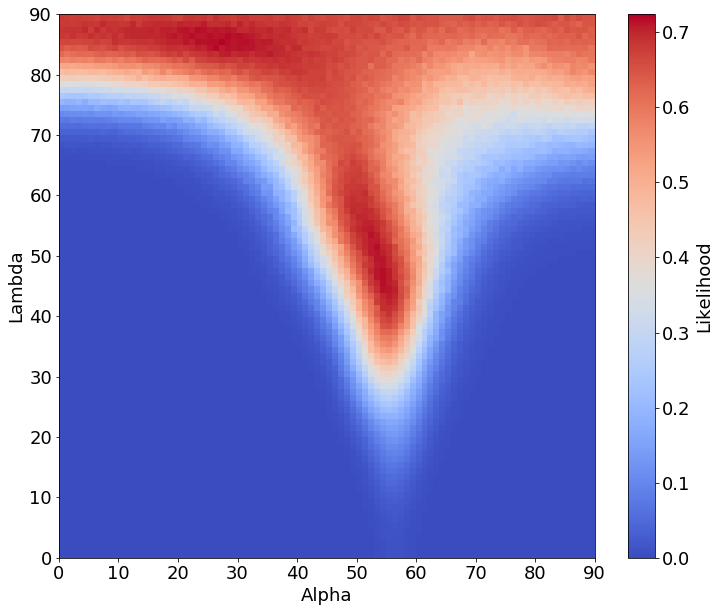

In [39]:
chifig = plt.figure(figsize=(12,10))
#plt.pcolor(alpha_vec,lamda_vec,chi2/2,cmap='coolwarm')

plt.pcolor(alpha_vec,lamda_vec,likelihood,cmap='coolwarm')#,vmin=.5,vmax=1.01)
#plt.pcolor(alpha_vec,lamda_vec,likelihood,cmap='coolwarm')#,vmin=np.min(likelihood),vmax=np.max(likelihood))

#plt.pcolor(alpha_vec,lamda_vec,np.log(chi2),cmap='coolwarm_r')
#plt.pcolor(alpha_vec,lamda_vec,chi2,cmap='coolwarm_r')

#plt.pcolor(alpha_vec,lamda_vec,ksprob,cmap='coolwarm')

#plt.colorbar(label='K-S Probability')
plt.colorbar(label='Likelihood')# $e^{-\chi^2/2}$')
#plt.colorbar(label='$\log \chi^2$')

plt.xlabel('Alpha')
plt.ylabel('Lambda')
#plt.xlim(0,20)
#plt.ylim(70,90)
plt.show()

Text(0,0.5,'Probability')

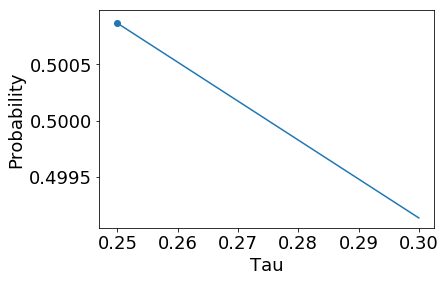

In [111]:
marginal_tau = np.sum(likelihood,axis=(0,1))
plt.plot(tau_vec,marginal_tau/np.sum(marginal_tau))
tindx = np.argmax(marginal_tau/np.sum(marginal_tau))
plt.scatter(tau_vec[tindx],marginal_tau[tindx]/np.sum(marginal_tau))
plt.xlabel('Tau')
plt.ylabel('Probability')

In [ ]:
marginal_tau = np.sum(chi2,axis=(0,1))
plt.plot(tau_vec,marginal_tau/np.sum(marginal_tau))
tindx = np.argmax(marginal_tau/np.sum(marginal_tau))
plt.scatter(tau_vec[tindx],marginal_tau[tindx]/np.sum(marginal_tau))
plt.xlabel('Tau')
plt.ylabel('Probability')

In [34]:
marginal_lambda = np.sum(ksprob,axis=1)
plt.plot(lamda_vec,marginal_lambda/np.sum(marginal_lambda))
lindx = np.argmax(marginal_lambda/np.sum(marginal_lambda))
plt.scatter(lamda_vec[lindx],marginal_lambda[lindx]/np.sum(marginal_lambda))
plt.xlabel('Lambda')
plt.ylabel('Probability')

NameError: name 'ksprob' is not defined

In [166]:
lindx

89

Text(0,0.5,'Probability')

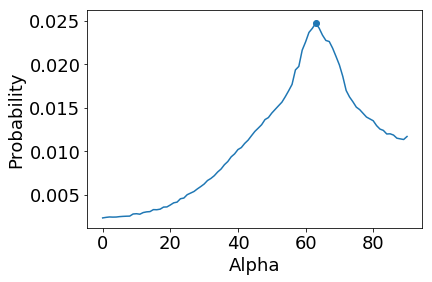

In [167]:
marginal_alpha = np.sum(ksprob,axis=0)

plt.plot(alpha_vec,marginal_alpha/np.sum(marginal_alpha))
aindx = np.argmax(marginal_alpha/np.sum(marginal_alpha))
plt.scatter(alpha_vec[aindx],marginal_alpha[aindx]/np.sum(marginal_alpha))

plt.xlabel('Alpha')
plt.ylabel('Probability')

In [145]:
aindx

66

Text(0, 0.5, 'Probability')

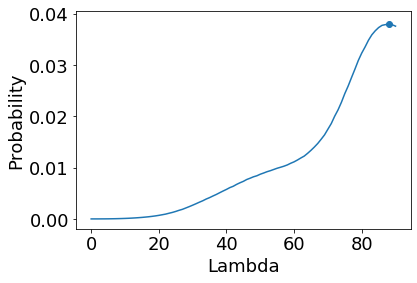

In [35]:
marginal_lambda = np.sum(likelihood,axis=1)
plt.plot(lamda_vec,marginal_lambda/np.sum(marginal_lambda))
lindx = np.argmax(marginal_lambda/np.sum(marginal_lambda))
plt.scatter(lamda_vec[lindx],marginal_lambda[lindx]/np.sum(marginal_lambda))
plt.xlabel('Lambda')
plt.ylabel('Probability')

In [36]:
lindx

88

In [39]:
l_int_indx = lamda_vec > 65
#l_int_indx = lamda_vec > 38
np.trapz(marginal_lambda[l_int_indx],lamda_vec[l_int_indx])/np.trapz(marginal_lambda,lamda_vec)

0.6853317105436268

In [40]:
l_int_indx = lamda_vec > 36
#l_int_indx = lamda_vec > 38
np.trapz(marginal_lambda[l_int_indx],lamda_vec[l_int_indx])/np.trapz(marginal_lambda,lamda_vec)

0.9529493604377003

Text(0, 0.5, 'Probability')

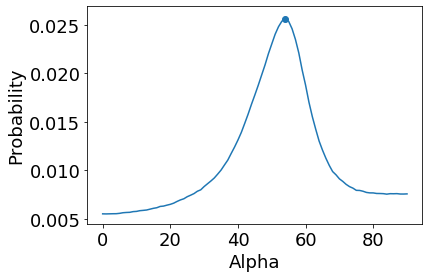

In [37]:
marginal_alpha = np.sum(likelihood,axis=0)

plt.plot(alpha_vec,marginal_alpha/np.sum(marginal_alpha))
aindx = np.argmax(marginal_alpha/np.sum(marginal_alpha))
plt.scatter(alpha_vec[aindx],marginal_alpha[aindx]/np.sum(marginal_alpha))

plt.xlabel('Alpha')
plt.ylabel('Probability')

In [38]:
aindx

54

In [41]:
a_int_indx = (alpha_vec > 32) & (alpha_vec < 78)
#l_int_indx = lamda_vec > 38
np.trapz(marginal_alpha[a_int_indx],alpha_vec[a_int_indx])/np.trapz(marginal_alpha,alpha_vec)

0.6816310549722215

In [251]:
finalresults[np.isnan(finalresults['RV'])]['rv_synt']

23.7343151694


In [42]:
Ltbl =Table(likelihood)

In [43]:
hdul = fits.HDUList()
hdul.append(fits.PrimaryHDU())
hdul.append(fits.ImageHDU(data=likelihood))

In [44]:
hdul.writeto('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig8/fig8_likelihood.fits',overwrite=True)

In [45]:
aindx

54

In [151]:
likelihood.tofile('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig8/fig8_likelihood.csv',sep=',')

In [12]:
likelihood = fits.open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig8/fig8_likelihood.fits')[1].data

In [152]:
ksprob.tofile('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/ksprob.txt',sep=',')

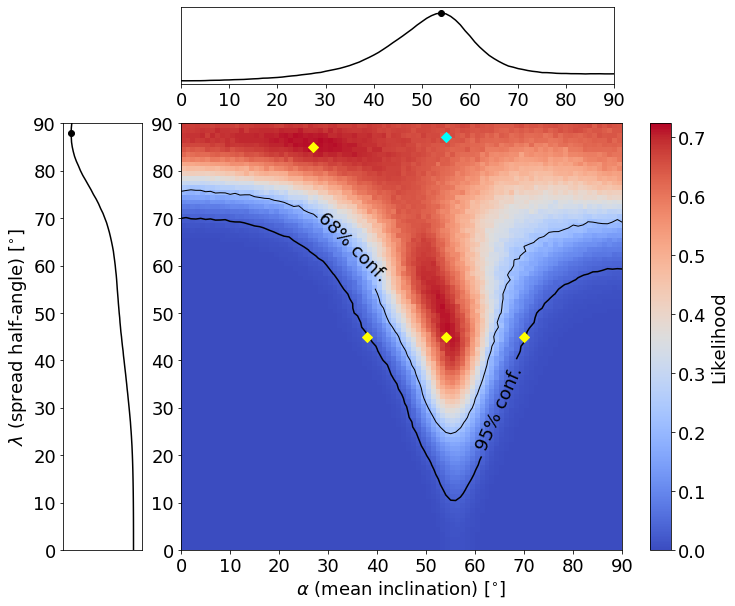

In [274]:
chifig = plt.figure(figsize=(12,10))
gs=gridspec.GridSpec(ncols=6, nrows=5,hspace=0.5,wspace=0.5)
ax1=plt.subplot(gs[1:,1:])
ax2=plt.subplot(gs[0:1,1:5])
ax3=plt.subplot(gs[1:5,0:1])

#ax1=plt.subplot(gs[2:,2:])
#ax2=plt.subplot(gs[0:2,2:10])
#ax3=plt.subplot(gs[2:10,0:2])


#chifig = plt.figure(figsize=(12,10))
#plt.pcolor(alpha_vec,lamda_vec,chi2/2,cmap='coolwarm')

p = ax1.pcolor(alpha_vec,lamda_vec,likelihood,cmap='coolwarm')#,vmin=.5,vmax=1.01)
cs = ax1.contour(likelihood,levels=[(1-0.95)*np.max(likelihood),(1-0.68)*np.max(likelihood)],colors=['black','black'],linewidths=[1.5,1])
ax1.clabel(cs,[(1-0.95)*np.max(likelihood),(1-0.68)*np.max(likelihood)],fmt={(1-0.95)*np.max(likelihood):'95% conf.',(1-0.68)*np.max(likelihood):'68% conf.'},inline=True)

ax1.set_xticks([0,10,20,30,40,50,60,70,80,90])
#85 27 45 54
ax1.scatter([38],[45],color='yellow',marker='D',s=50,zorder=2)
ax1.scatter([70],[45],color='yellow',marker='D',s=50,zorder=2)
ax1.scatter([54],[45],color='yellow',marker='D',s=50)
ax1.scatter([27],[85],color='yellow',marker='D',s=50)
ax1.scatter([54],[87],color='cyan',marker='D',s=50)



ax2.plot(alpha_vec,marginal_alpha/np.sum(marginal_alpha),color='black')
#ax2.plot(alpha_vec,marginal_alpha,color='black')

ax2.set_xlim(0,90)
ax2.set_xticks([0,10,20,30,40,50,60,70,80,90])
ax2.set_yticks([])
aindx = np.argmax(marginal_alpha/np.sum(marginal_alpha))
ax2.scatter(alpha_vec[aindx],marginal_alpha[aindx]/np.sum(marginal_alpha),color='black')
#plt.pcolor(alpha_vec,lamda_vec,likelihood,cmap='coolwarm')#,vmin=np.min(likelihood),vmax=np.max(likelihood))
ax3.plot(marginal_lambda/np.sum(marginal_lambda),lamda_vec,color='black')
lindx = np.argmax(marginal_lambda/np.sum(marginal_lambda))
ax3.scatter(marginal_lambda[lindx]/np.sum(marginal_lambda),lamda_vec[lindx],color='black')
ax3.set_ylim(0,90)
ax3.set_xticks([])
ax3.set_xlim(np.max(marginal_lambda/np.sum(marginal_lambda))+0.005, np.min(marginal_lambda/np.sum(marginal_lambda))-.005)
#plt.pcolor(alpha_vec,lamda_vec,np.log(chi2),cmap='coolwarm_r')
#plt.pcolor(alpha_vec,lamda_vec,chi2,cmap='coolwarm_r')

#plt.pcolor(alpha_vec,lamda_vec,ksprob,cmap='coolwarm')

#plt.colorbar(label='K-S Probability')

plt.colorbar(p,label='Likelihood',ax=ax1)# $e^{-\chi^2/2}$')
#plt.colorbar(label='$\log \chi^2$')

ax1.set_xlabel(r'$\alpha$ (mean inclination) [$^{\circ}$]')
plt.ylabel(r'$\lambda$ (spread half-angle) [$^{\circ}$]')
#plt.xlim(0,20)
#plt.ylim(70,90)
plt.show()
chifig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/chi2fig_cdips_contours_points.pdf',bbox_inches='tight')

In [197]:
Table(data=[lamda_vec,marginal_lambda/np.sum(marginal_lambda)],names=['lambda','probability']).write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig8/fig8_lambda.txt',format='ascii')
Table(data=[alpha_vec,marginal_alpha/np.sum(marginal_alpha)],names=['alpha','probability']).write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig8/fig8_alpha.txt',format='ascii')



In [198]:
marginal_lambda = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig8/fig8_lambda.txt')['probability']
marginal_alpha = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig8/fig8_alpha.txt')['probability']

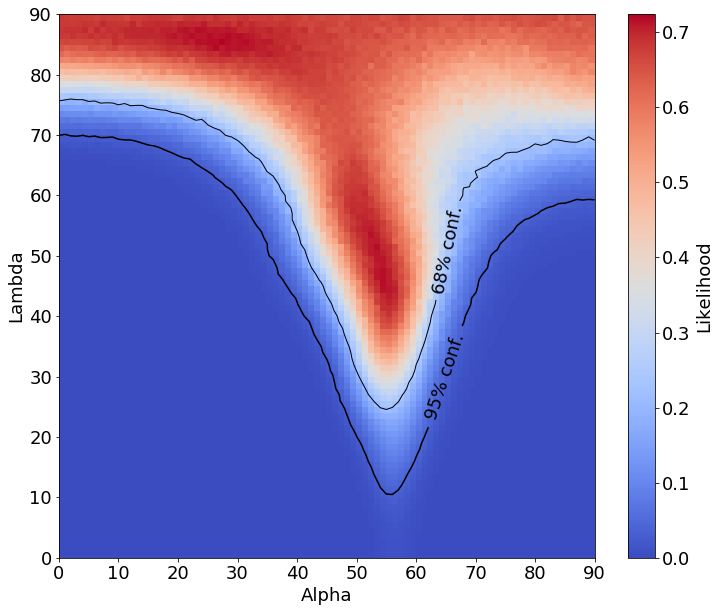

In [152]:
chifig = plt.figure(figsize=(12,10))
#plt.pcolor(alpha_vec,lamda_vec,chi2/2,cmap='coolwarm')

plt.pcolor(alpha_vec,lamda_vec,likelihood,cmap='coolwarm')#,vmin=.5,vmax=1.01)
#plt.pcolor(alpha_vec,lamda_vec,likelihood,cmap='coolwarm')#,vmin=np.min(likelihood),vmax=np.max(likelihood))

#plt.pcolor(alpha_vec,lamda_vec,np.log(chi2),cmap='coolwarm_r')
#plt.pcolor(alpha_vec,lamda_vec,chi2,cmap='coolwarm_r')

#plt.pcolor(alpha_vec,lamda_vec,ksprob,cmap='coolwarm')

#plt.colorbar(label='K-S Probability')
plt.colorbar(label='Likelihood')# $e^{-\chi^2/2}$')
#plt.colorbar(label='$\log \chi^2$')
cs = plt.contour(likelihood,levels=[(1-0.95)*np.max(likelihood),(1-0.68)*np.max(likelihood)],colors=['black','black'],linewidths=[1.5,1])
plt.clabel(cs,[(1-0.95)*np.max(likelihood),(1-0.68)*np.max(likelihood)],fmt={(1-0.95)*np.max(likelihood):'95% conf.',(1-0.68)*np.max(likelihood):'68% conf.'},inline=True)

plt.xlabel('Alpha')
plt.ylabel('Lambda')
#plt.xlim(0,20)
#plt.ylim(70,90)
plt.show()

chifig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/likelihood_contours.pdf',bbox_inches='tight')


In [18]:
#np.max(likelihood)*.05

twosigma_vals = cs.allsegs[0][0].astype(int)
onesigma_vals = cs.allsegs[1][0].astype(int)

In [102]:

twosigma_vals


array([[ 0, 69],
       [ 0, 70],
       [ 1, 70],
       [ 1, 70],
       [ 2, 69],
       [ 3, 69],
       [ 4, 69],
       [ 5, 69],
       [ 6, 69],
       [ 7, 69],
       [ 8, 69],
       [ 9, 69],
       [10, 69],
       [11, 69],
       [12, 69],
       [12, 69],
       [13, 68],
       [14, 68],
       [15, 68],
       [16, 68],
       [16, 68],
       [17, 67],
       [18, 67],
       [19, 67],
       [19, 67],
       [20, 66],
       [21, 66],
       [22, 66],
       [22, 66],
       [23, 65],
       [23, 65],
       [24, 64],
       [24, 64],
       [25, 63],
       [26, 63],
       [26, 63],
       [27, 62],
       [27, 62],
       [28, 61],
       [28, 61],
       [29, 60],
       [29, 60],
       [30, 59],
       [30, 59],
       [31, 58],
       [31, 58],
       [31, 57],
       [32, 56],
       [32, 56],
       [33, 55],
       [33, 55],
       [34, 54],
       [34, 54],
       [34, 53],
       [34, 52],
       [35, 51],
       [35, 51],
       [35, 50],
       [36, 49

In [1735]:
tablefile = '/Users/bhealy/Documents/PhD_Thesis/Catalogs/table1.fits'
tablehdu = fits.open(tablefile)
table = tablehdu[1].data
cat = table
clustmask = cat['cluster'] == 'NGC_2516'
Ctbl = Table(cat[clustmask])
cra = Ctbl['ra'].data[0]
cdec = Ctbl['dec'].data[0]
cpmra = Ctbl['pmra'].data[0]
cpmdec = Ctbl['pmdec'].data[0]
cdist = Ctbl['dmode'].data[0]


<IPython.core.display.Javascript object>


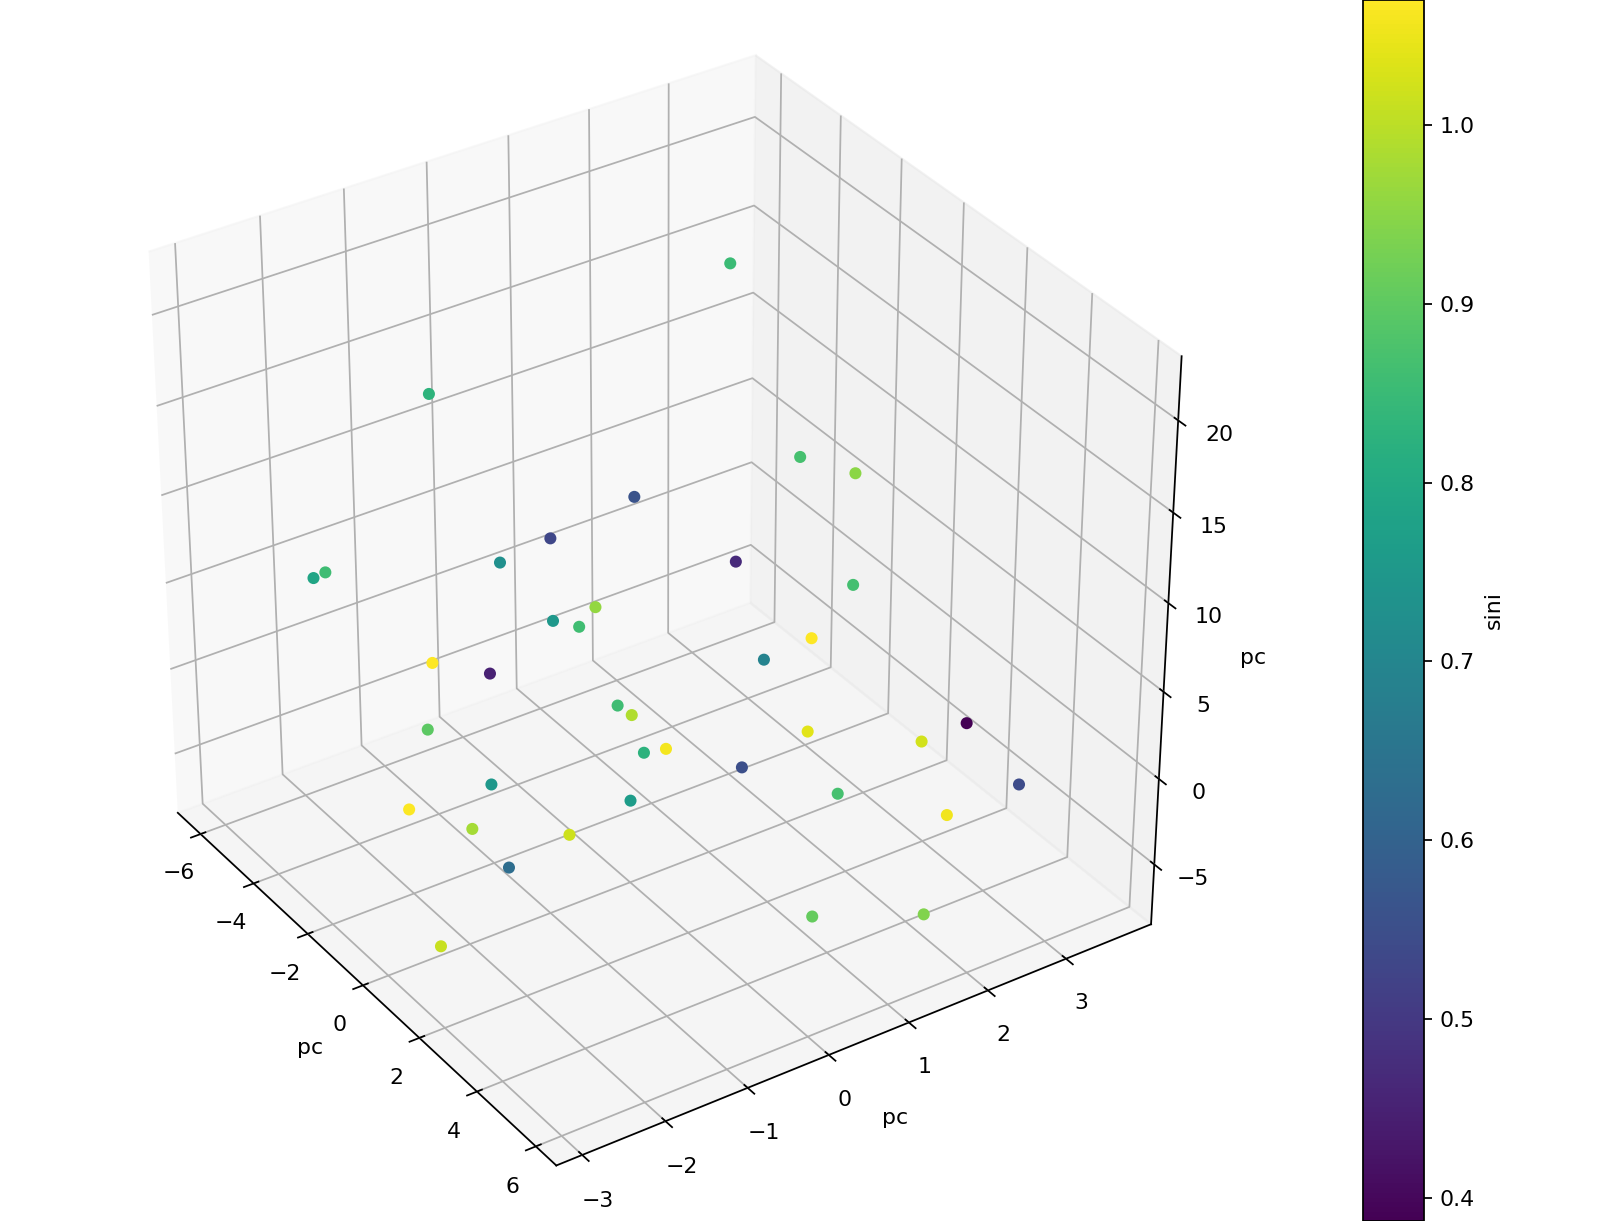

Text(0.5,0,'pc')

In [1763]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
p = ax.scatter((joined_finalresultstbl['ra']-cra)*(np.pi/180)*(1e3/joined_finalresultstbl['parallax']),(joined_finalresultstbl['dec']-cdec)*(np.pi/180)*(1e3/joined_finalresultstbl['parallax']),1e3/joined_finalresultstbl['parallax'] - cdist,c=joined_finalresultstbl['bayes_sini'],depthshade=False)
fig.colorbar(p,ax=ax,label='sini')
ax.set_xlabel('pc')
ax.set_ylabel('pc')
ax.set_zlabel('pc')

#ax.set_zticklabels([])
#ax.set_yticklabels([])
#ax.set_xticklabels([])


(array([3., 6., 9., 4., 7., 5., 3., 0., 0., 2.]),
 array([402.38187905, 405.17258799, 407.96329692, 410.75400585,
        413.54471478, 416.33542372, 419.12613265, 421.91684158,
        424.70755051, 427.49825944, 430.28896838]),
 <a list of 10 Patch objects>)

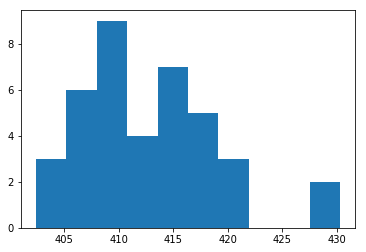

In [1743]:
%matplotlib inline
plt.hist(1e3/joined_finalresultstbl['parallax'])

In [1753]:
joined_finalresultstbl.sort('parallax')

In [1759]:
joined_finalresultstbl

source_id,AV_SFD,AV_SandF,Cluster,E_B_V_SFD,E_B_V_SandF,Hmag,Icmag,Jmag,Kmag,Nsp,Object,RV,S/N,Survey,al_fe,alpha_fe,b,ba_fe,bp_rp,c_fe,ca_fe,chi2_cannon,classification,cluster,co_fe,cr_fe,cu_fe,cutout_size,dec,dec_parallax_corr,dec_pmdec_corr,dec_pmra_corr,dej2000,e_al_fe,e_alpha_fe,e_ba_fe,e_c_fe,e_ca_fe,e_co_fe,e_cr_fe,e_cu_fe,e_eu_fe,e_fe_h,e_hmag,e_jmag,e_k_fe,e_kmag,e_la_fe,e_li_fe,e_logg,e_mg_fe,e_mn_fe,e_na_fe,e_ni_fe,e_o_fe,e_rv_nogr_obst,e_rv_obst,e_rv_synt,e_sc_fe,e_si_fe,e_teff,e_ti_fe,e_v_fe,e_vmic,e_vsini,e_y_fe,e_zn_fe,errmsg,eu_fe,fe_h,field_id,flag_al_fe,flag_ba_fe,flag_c_fe,flag_ca_fe,flag_cannon,flag_co_fe,flag_cr_fe,flag_cu_fe,flag_eu_fe,flag_k_fe,flag_la_fe,flag_li_fe,flag_mg_fe,flag_mn_fe,flag_na_fe,flag_ni_fe,flag_o_fe,flag_sc_fe,flag_si_fe,flag_ti_fe,flag_v_fe,flag_y_fe,flag_zn_fe,gaia_r,hmag,jmag,k_fe,kmag,l,la_fe,li_fe,logTeff,logg,max_E_B_V_SFD,max_E_B_V_SandF,mean_E_B_V_SFD,mean_E_B_V_SandF,mg_fe,min_E_B_V_SFD,min_E_B_V_SandF,mn_fe,na_fe,ndfclass,ni_fe,o_fe,pRV,parallax,parallax_err,parallax_error,parallax_pmdec_corr,parallax_pmra_corr,period,period_unc,phot_g_mean_mag,phot_g_n_obs,pmdec,pmdec_error,pmra,pmra_error,pmra_pmdec_corr,proba,pvsini,ra,ra_dec_corr,ra_parallax_corr,ra_pmdec_corr,ra_pmra_corr,raj2000,rv_nogr_obst,rv_obst,rv_synt,sc_fe,si_fe,snr_c1,snr_c2,snr_c3,snr_c4,sobject_id,sp_label_distance,star_id,stdev_E_B_V_SFD,stdev_E_B_V_SandF,teff,ti_fe,v_fe,vmag_jk,vmic,vsini,y_fe,zn_fe,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,exofast_r,r_hi_err,r_lo_err,exofast_teff,teff_hi_err,teff_lo_err,lum,lumhierr,lumloerr,sini,sini_fracerr,bayes_sini,bayes_sini_lo_err,bayes_sini_hi_err
int64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,str16,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,str1,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5290739937276199168,0.5932,0.5102,NGC2516,0.1914,0.1646,12.26,0.0,12.78,12.17,2.0,07571215-6033090,23.11,63.93,GES,nan,nan,-15.856907716932549,nan,1.2207375,nan,nan,nan,C,NGC_2516,nan,nan,nan,5.0,-60.55244766708006,0.34532517,-0.073668525,-0.068477355,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,66.11428347655293,nan,nan,nan,1.7600000000000002,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.7590082883834839,nan,nan,nan,nan,273.57969309826,nan,nan,3.626,nan,0.2012,0.173,0.1929,0.1659,nan,0.1873,0.1611,nan,nan,nan,nan,nan,0.35,2.3240196088962195,0.020478406837300747,0.020478406837300747,0.07876566,0.10146824,0.9791847333660825,0.0,14.352622,379,10.64883259578083,0.044790693397845416,-4.894071191135896,0.039022696600599927,-0.09459209,0.69999998807907

(array([   56.,   369.,  1417.,  3734.,  5882.,  7466.,  9508., 14314.,
        23647., 33607.]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <a list of 10 Patch objects>)

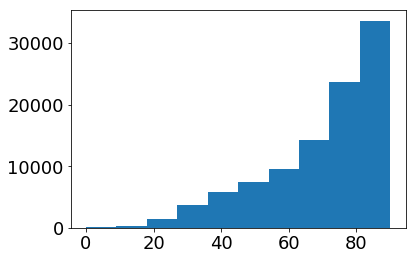

In [898]:
sampled_lambda = np.array(choices(lamda_vec,marginal_lambda/np.sum(marginal_lambda),k=100000))
plt.hist(sampled_lambda)


In [1035]:
#print(np.percentile(sampled_lambda,16),np.median(sampled_lambda),np.percentile(sampled_lambda,84))
print(np.percentile(sampled_lambda,34))


67.0


(array([ 4937.,  5287.,  6299.,  8131., 12141., 19344., 18374., 10207.,
         7468.,  7812.]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <a list of 10 Patch objects>)

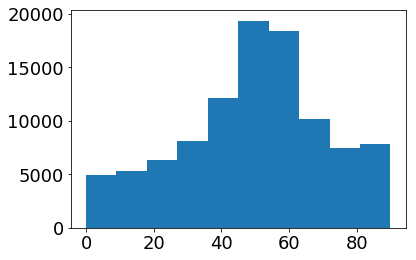

In [900]:
sampled_alpha=np.array(choices(alpha_vec,marginal_alpha/np.sum(marginal_alpha),k=100000))
plt.hist(sampled_alpha)


In [816]:
print(np.percentile(sampled_alpha,16),np.median(sampled_alpha),np.percentile(sampled_alpha,84))


22.0 51.0 74.0


In [231]:
np.argwhere(likelihood == np.nanmax(likelihood))


array([[85, 27]])

In [241]:
#np.argwhere(np.exp(-chi2/2) == np.nanmax(np.exp(-chi2/2)))
#np.argwhere(ksprob == np.nanmax(ksprob))
np.argwhere(likelihood >= .991*np.nanmax(likelihood))

array([[45, 54],
       [84, 26],
       [85, 27],
       [85, 28],
       [86, 28],
       [86, 30],
       [87, 23]])

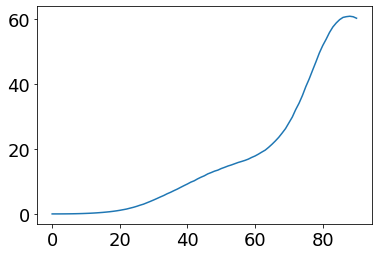

In [234]:
plt.plot(np.sum(likelihood,axis=1))

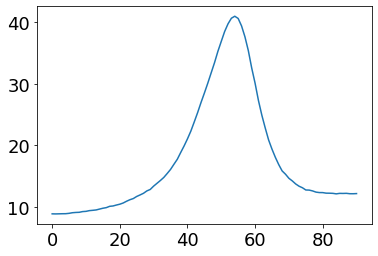

In [236]:
plt.plot(np.sum(likelihood,axis=0))

In [743]:
np.exp(-chi2/2)[47,54]

0.9846045677376263

In [744]:
likelihood = likelihood.reshape(91*91)

In [745]:
np.sort(likelihood)[-1]

0.9846045677376263

In [749]:
np.argwhere(np.exp(-chi2/2) == np.sort(likelihood)[-4])

array([[89, 20]])

In [376]:
alpha_vec[20], lamda_vec[85]

(20, 85)

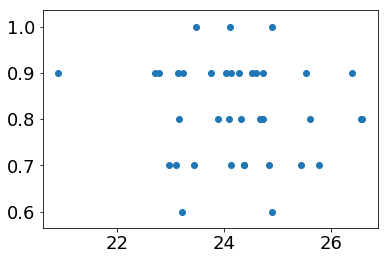

In [784]:
plt.scatter(joined_finalresultstbl['RV'],joined_finalresultstbl['proba'])

In [582]:
joined_finalresultstbl['pRV']

nan
0.26
nan
0.18
0.19
0.53
0.26
0.26
0.18
0.19
0.19


In [719]:
(joined_finalresultstbl['bayes_sini_hi_err']+joined_finalresultstbl['bayes_sini_lo_err'])/2

0.0471981418869849
0.05328629822091557
0.03943833057573756
0.04293732911852516
0.03640799033281705
0.02462989186345066
0.026398778382721755
0.08241191464546549
0.012845893318357657
0.050438644720914416
0.04104131386274995


In [576]:
np.sqrt(1-finalresults['sini']**2)

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


nan
0.10544649278196137
0.7627130490048842
0.446371813968642
0.896340585198013
0.781340794413303
0.6648125048809332
0.23008679453036332
0.7366228604269516
0.5327095717440603
0.9820615183609405


In [570]:
for i in range(len(finalresults)):
    fig = plt.figure(figsize=(8,8))
    plt.plot(cosi_all[i],posteriors_all[i]/np.median(posteriors_all[i]),color='navy')
    plt.xlabel('cos(i)')
    plt.ylabel('Probability density')
    fig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/posteriors/'+np.str(finalresults['source_id'][i])+'_posterior.pdf')
    plt.close()

In [524]:
eps = sys.float_info.epsilon

varr = np.arange(eps,150.0-eps,0.01)
cosiarr = np.arange(eps,1.00-eps,0.001)

varr = np.linspace(0,150,10000)
cosiarr = np.linspace(0,0.999,1000)
#cosiarr = np.linspace(0,1,1000)

In [9]:
#likelihood = lambda v,cosi,meanv,meanu,sigv,sigu: norm.pdf(v,meanv,sigv) * norm.pdf(v*np.sqrt(1-cosi**2),meanu,sigu) * uniform.pdf(v,0,150)

likelihood_spec = lambda v,cosi,meanv,meanu,sigv,sigu: norm.pdf(v,meanv,sigv) * norm.pdf(v*np.sqrt(1-cosi**2),meanu,sigu) * uniform.pdf(v,0,v)

def gaussian(values,mean,sig):
    yvals = (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(values-mean)**2/(2*sig**2))
    return yvals

def likelihood(v,varr,cosi,meanv,sigv,meanu,sigu):
    L_v = norm.pdf(v,meanv,sigv)
    
    L_u_full = norm.pdf(varr*np.sqrt(1-cosi**2),meanu,sigu)
    L_u = norm.pdf(v*np.sqrt(1-cosi**2),meanu,sigu)
    area = np.trapz(L_u_full,varr)
    L_u = L_u/area
    
    P_v = uniform.pdf(v,0,np.max(v))
    
    return L_v * L_u * P_v
    

In [ ]:
plt.plot(varr, likelihood(varr,varr,0.2,10,2,9.8,2)

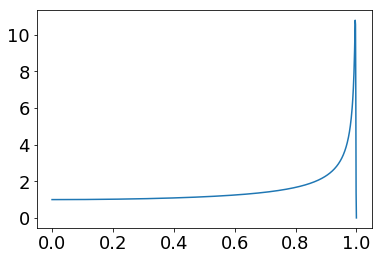

In [447]:
areas=[]
for i in range(len(cosiarr)):
    areas += [np.trapz(norm.pdf(varr*np.sqrt(1-cosiarr[i]**2),9.8,2),varr)]
areas = np.array(areas)
plt.plot(cosiarr,areas)

In [490]:
#cosi=0.3
lv = norm.pdf(varr,10,2)
lu = norm.pdf(varr*np.sqrt(1-cosi**2),9.8,2)
area = np.trapz(lu,varr)
lu = lu/area
pv = uniform.pdf(varr,0,np.max(varr))
pcosi = uniform.pdf(cosiarr,0,1)

In [10]:
def calc_posterior(meanv,sigv,meanu,sigu):

    varr = np.linspace(0,150,10000)
    cosiarr = np.linspace(0,0.999,1000)

    lv = norm.pdf(varr,meanv,sigv)
    pv = uniform.pdf(varr,0,np.max(varr))
    pcosi = uniform.pdf(cosiarr,0,1)
    post = []
    for i in range(len(cosiarr)):
        lu = norm.pdf(varr*np.sqrt(1-cosiarr[i]**2),meanu,sigu)
        area = np.trapz(lu,varr)
        lu = lu/area
        post += [pcosi[i]*np.trapz(lv*lu*pv,varr)]
    post = np.array(post)
    
    return cosiarr,post

In [535]:
c,p = calc_posterior(10,2,9.5,2)

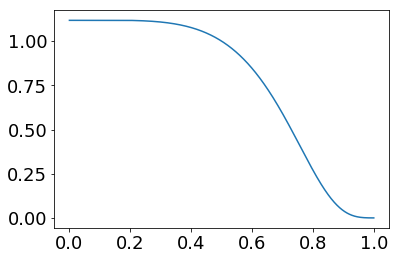

In [548]:
plt.plot(c,p/np.median(p))


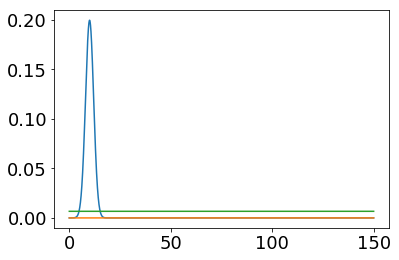

In [469]:
plt.plot(varr,norm.pdf(varr,10,2))
plt.plot(varr,norm.pdf(varr*np.sqrt(1-1**2),9.8,2))
area = np.trapz(norm.pdf(varr*np.sqrt(1-1**2),9.8,2),varr)
plt.plot(varr,norm.pdf(varr*np.sqrt(1-1**2),9.8,2)/area)
#plt.plot(varr*np.sqrt(1-0.7**2),norm.pdf(varr*np.sqrt(1-0.7**2),9.8,2))
#plt.plot(varr,uniform.pdf(varr,0,10))
#plt.plot(cosiarr,uniform.pdf(cosiarr,0,1))

#plt.xlim(0,20)

In [371]:
np.trapz(norm.pdf(varr*np.sqrt(1-0.8**2),9.8,2)/area,varr)

1.0

In [367]:
np.trapz(norm.pdf(varr,10,2),varr)

0.9999997133329417

In [415]:
posterior = []
for i in range(len(cosiarr)):
    #posterior += [uniform.pdf(cosiarr[i],0,1) * integrate.quad(likelihood,0,100,(cosiarr[i],10,9.8,2,2))[0]]
    posterior += [uniform.pdf(cosiarr[i],0,1) * integrate.quad(likelihood,0,50,(varr,cosiarr[i],10,2,9.8,2))[0]]
posterior = np.array(posterior)

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


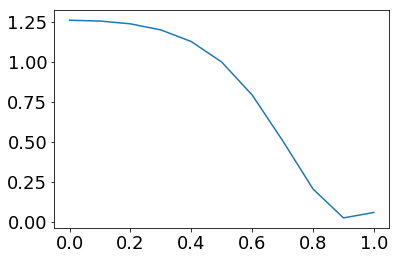

In [416]:
plt.plot(cosiarr,posterior/np.median(posterior))

(0, 20)

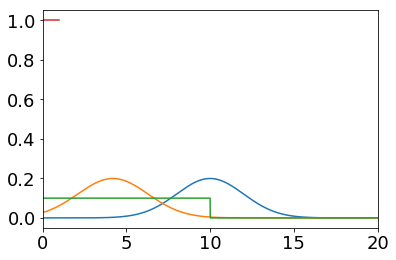

In [300]:
plt.plot(varr,norm.pdf(varr,10,2))
plt.plot(varr,norm.pdf(varr*np.sqrt(1-0.3**2),4,2))
plt.plot(varr,uniform.pdf(varr,0,10))
plt.plot(cosiarr,uniform.pdf(cosiarr,0,1))

plt.xlim(0,20)

In [417]:
posterior = []
for i in range(len(cosiarr)):
    #posterior += [uniform.pdf(cosiarr[i],0,1) * integrate.quad(likelihood,0,100,(cosiarr[i],10,4,2,2))[0]]
    posterior += [uniform.pdf(cosiarr[i],0,1) * integrate.quad(likelihood,0,50,(varr,cosiarr[i],10,2,4,2))[0]]
posterior = np.array(posterior)

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


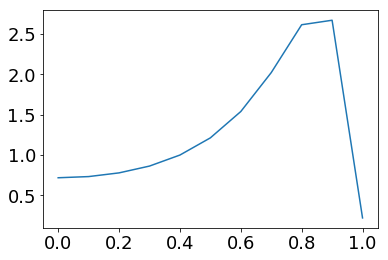

In [418]:
#plt.plot(cosiarr,posterior)
plt.plot(cosiarr,posterior/np.median(posterior))

In [92]:
def gaussian(mean,sig):
    yvals = (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(xarr-mean)**2/(2*sig**2))
    return yvals

In [93]:
uniform_cosi = np.random.uniform(0,1,len(xarr))

(array([14967., 14965., 15076., 14912., 15032., 15076., 14980., 14818.,
        15152., 15032.]),
 array([2.54981097e-05, 1.00022404e-01, 2.00019311e-01, 3.00016217e-01,
        4.00013123e-01, 5.00010029e-01, 6.00006935e-01, 7.00003841e-01,
        8.00000748e-01, 8.99997654e-01, 9.99994560e-01]),
 <a list of 10 Patch objects>)

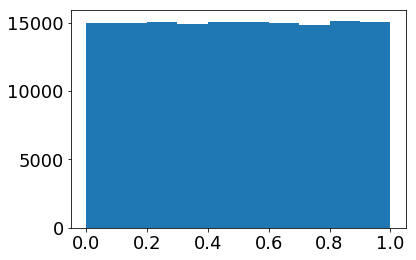

In [94]:
plt.hist(uniform_cosi)

In [66]:
lamb_gauss = lambda x,mean,sig: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(x-mean)**2/(2*sig**2))

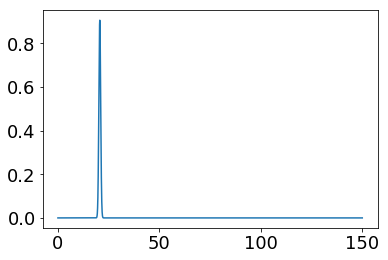

In [84]:
plt.plot(xarr,norm.pdf(xarr,V[0],V_err[0]))

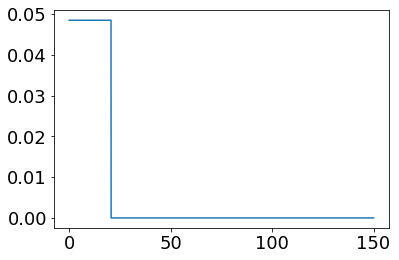

In [89]:
plt.plot(xarr,uniform.pdf(xarr,loc=0,scale=V[0]))
#plt.xlim(0,2)

In [95]:
# L_v, L_u, Pcosi, Pv
L_v = norm.pdf(xarr,10,2)
L_u = norm.pdf(xarr,9.8,2)
Pcosi = uniform.pdf(xarr,0,1)
Pv = uniform.pdf(xarr,0,np.max(xarr))

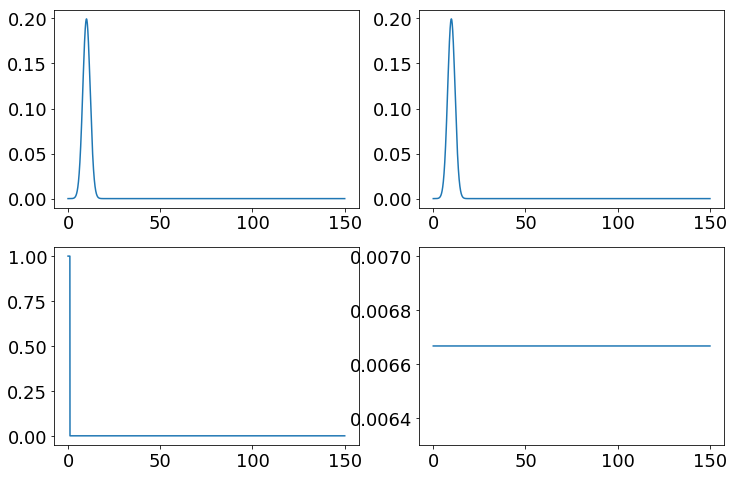

In [111]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].plot(xarr,L_v)
ax[0,1].plot(xarr,L_u)
ax[1,0].plot(xarr,Pcosi)
ax[1,1].plot(xarr,Pv)